In [1086]:
import numpy as np
import sympy
from sympy import Symbol, Eq, symbols, Function, I, zeros, sqrt, Rational, simplify
import matplotlib.pyplot as plt
from optical_bloch.utils.general import flatten
from optical_bloch import Hamiltonian, Dissipator, BlochEquations

from tqdm import tqdm

In [1087]:
def anti_commute(A,B):
    """
    Calculate the anti-commutator between A and B; AB+BA.
    Parameters:
    A   : 2D array or matrix
    B   : 2D array or matrix
    Returns:
    2D array or matrix AB+BA
    """
    return A@B+B@A

def commute(A,B):
    """
    Calculate the commutator between A and B; AB-BA.
    Parameters:
    A   : 2D array or matrix
    B   : 2D array or matrix
    Returns:
    2D array or matrix AB+BA
    """
    return A@B-B@A

In [1088]:
from sympy import Symbol, Eq, symbols, Function, I, zeros, sqrt, Rational, simplify
from optical_bloch.utils.general import flatten

def generate_density_matrix(levels):
    density_matrix = sympy.zeros(levels, levels)
    t = Symbol('t', real = True)
    for i in range(levels):
        for j in range(levels):
            # \u03C1 is unicode for ρ, chr(0x2080+i) is unicode for
            # subscript num(i), resulting in ρ₀₀(t) for example
            density_matrix[i,j] = Function(u'\u03C1{0}{1}'. \
                                format(chr(0x2080+i), chr(0x2080+j)))(t)
    return density_matrix

class DissipatorNoConjugate:
    """
    Class for setting up the dissipator for the optical Bloch equations.
    """
    def __init__(self, levels):
        """
        Parameters:
        levels  : number of levels in the optical Bloch equations system
        """
        self.density_matrix = zeros(levels, levels)
        self.dissipator = zeros(levels, levels)
        self.branching = zeros(levels, levels)
        self.decay_rate = zeros(levels, 1)
        self.levels = levels

        self.generateDensityMatrix()

    def generateDensityMatrix(self):
        """
        Generate the symbolic density matrix
        """
        self.density_matrix = generate_density_matrix(self.levels)

    def addDecay(self, initial_state, final_state, gamma):
        """
        Add a decay to the dissipator matrix between two states, set by
        initial_state and final_state.
        Parameters:
        initial_state   : initial coupled state
        final_state     : final coupled state
        gamma           : decay rate from initial_state to final_state
        """
        if (initial_state >= self.levels) or (final_state >= self.levels):
            raise AssertionError('Specified state exceeds number of levels.')
        if initial_state == final_state:
            raise AssertionError('State cannot decay into itself.')

        # adding the decay to the dissipator
        G = zeros(self.levels, self.levels)
        G[final_state, initial_state] = sqrt(gamma)
        self.dissipator -= Rational(1/2) * \
            anti_commute(G.T@G, self.density_matrix) - G@self.density_matrix@G.T
        self.dissipator = simplify(self.dissipator)

        # update decay rates
        decay_rate_old = self.decay_rate[initial_state]
        decay_rate_new = decay_rate_old + gamma
        self.decay_rate[initial_state] += gamma

        # add the decay to the branching ratio matrix
        for i in range(self.levels):
            if i == final_state:
                self.branching[initial_state, i] = \
        (self.branching[initial_state, i]*decay_rate_old+gamma)/decay_rate_new
            else:
                self.branching[initial_state, i] = \
                (self.branching[initial_state, i]*decay_rate_old)/decay_rate_new

# 2 level system without decay

In [1295]:
A = Symbol(u'A', real = True)
E = Symbol(u'E', real = True)

δ = Symbol(u'δ', real = True)

wA = Symbol(u'ω_a', real = True)
WA = Symbol(u'Ω_a', real = True)
ham = Hamiltonian(2)

ham.addEnergies([A, E])
ham.addCoupling(0,1,WA,wA)

ham.eqnTransform()
ham.defineZero(E)
ham.defineStateDetuning(0,1,δ)

dis = Dissipator(ham.levels)

bloch = BlochEquations(dis.levels, dis.density_matrix, ham.transformed, dis.dissipator)

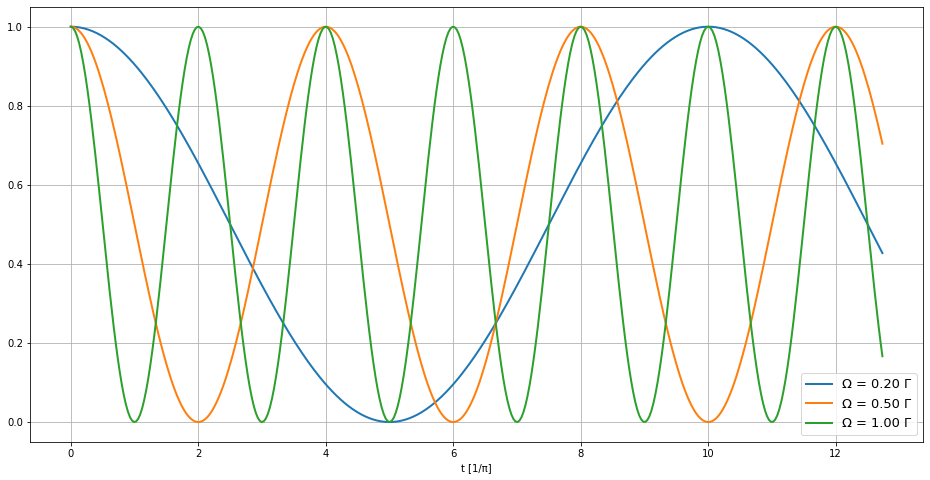

In [1296]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,40)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.2, 0.5, 1.0]:
    replacements = [(δ, 0), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x/(np.pi), y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
ax.set_xlabel('t [1/π]')
ax.legend(fontsize = 13)
ax.grid(True)

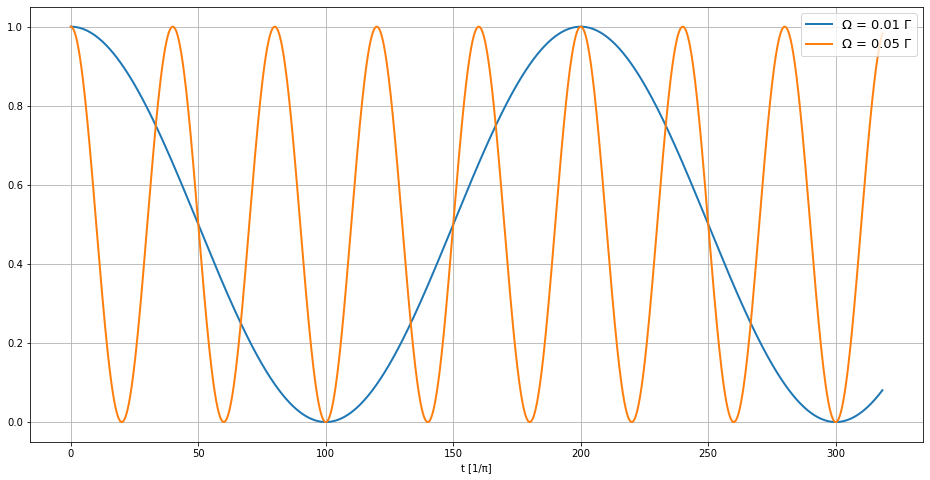

In [1297]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,1000)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.01, 0.05]:
    replacements = [(δ, 0), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x/(np.pi), y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
ax.set_xlabel('t [1/π]')
ax.legend(fontsize = 13)
ax.grid(True)

In [1298]:
def generate_density_matrix(levels):
    density_matrix = sympy.zeros(levels, levels)
    t = Symbol('t', real = True)
    for i in range(levels):
        for j in range(levels):
            # \u03C1 is unicode for ρ, chr(0x2080+i) is unicode for
            # subscript num(i), resulting in ρ₀₀(t) for example
            density_matrix[i,j] = Function(u'\u03C1{0}{1}'. \
                                format(chr(0x2080+i), chr(0x2080+j)))(t)
    return density_matrix

In [1299]:
density_matrix = generate_density_matrix(ham.levels)
bloch = BlochEquations(ham.levels, density_matrix, ham.transformed, dis.dissipator)

In [1300]:
from itertools import product
from sympy.solvers.ode.systems import dsolve_system

eqns = [
    Eq(bloch.equations.lhs[idx,idy], bloch.equations.rhs[idx,idy]) 
    for idx,idy in product(range(ham.levels),range(ham.levels))
]
funcs = [
    density_matrix[idx,idy] for idx,idy in product(range(ham.levels),range(ham.levels))
]
ics = {
    type(density_matrix[idx,idy])(0): 0 for idx,idy in product(range(ham.levels),range(ham.levels))
}
ics[type(density_matrix[0,0])(0)] = 1.0 

In [1301]:
sol = dsolve_system(eqns, funcs = funcs, ics = ics)

In [1302]:
sympy.simplify(sol[0][0].subs(δ, 0))

Eq(ρ₀₀(t), 0.5*cos(1.0*t*Abs(Ω_a)**1.0) + 0.5)

# 2 level system with decay

In [2282]:
A = Symbol(u'A', real = True)
E = Symbol(u'E', real = True)

δ = Symbol(u'δ', real = True)

wA = Symbol(u'ω_a', real = True)
WA = Symbol(u'Ω_a', real = True)

ga = Symbol(u"Γ_a", real = True)

ham = Hamiltonian(2)

ham.addEnergies([A, E])
ham.addCoupling(0,1,WA,wA)


ham.eqnTransform()
ham.defineZero(E)
ham.defineStateDetuning(0,1,δ)

dis = Dissipator(ham.levels)
dis.addDecay(1,0,ga)

bloch = BlochEquations(dis.levels, dis.density_matrix, ham.transformed, dis.dissipator)

In [2283]:
for key, value in bloch.solveSteadyStateSymbolic().items():
    display(key)
    display(value)
    print("="*25)
sympy.simplify(value.subs([(δ,0), (ga, 1)]))

ρ₀₀

(Γ_a**2 + Ω_a**2 + 4.0*δ**2)/(Γ_a**2 + 2.0*Ω_a**2 + 4.0*δ**2)

ρ₀₁

(-I*Γ_a*Ω_a + 2.0*Ω_a*δ)/(Γ_a**2 + 2.0*Ω_a**2 + 4.0*δ**2)

conjugate(ρ₀₁)

(I*Γ_a*Ω_a + 2.0*Ω_a*δ)/(Γ_a**2 + 2.0*Ω_a**2 + 4.0*δ**2)

ρ₁₁

Ω_a**2/(Γ_a**2 + 2.0*Ω_a**2 + 4.0*δ**2)

Ω_a**2/(2.0*Ω_a**2 + 1)

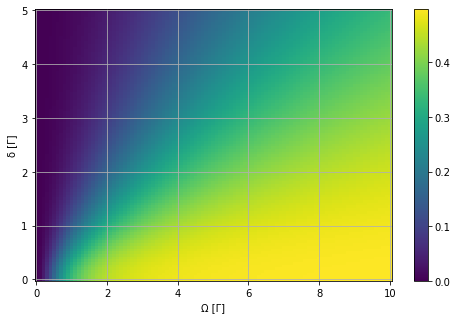

In [2284]:
f = sympy.lambdify([WA, ga, δ], value)

xi = np.linspace(0,10,101)
yi = np.linspace(0,5,101)
X,Y = np.meshgrid(xi, yi)

fig, ax = plt.subplots(figsize = (8,5))
c = ax.pcolormesh(X,Y,f(X,1,Y))
cbar = fig.colorbar(c)
ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("δ [Γ]")
ax.grid(True)

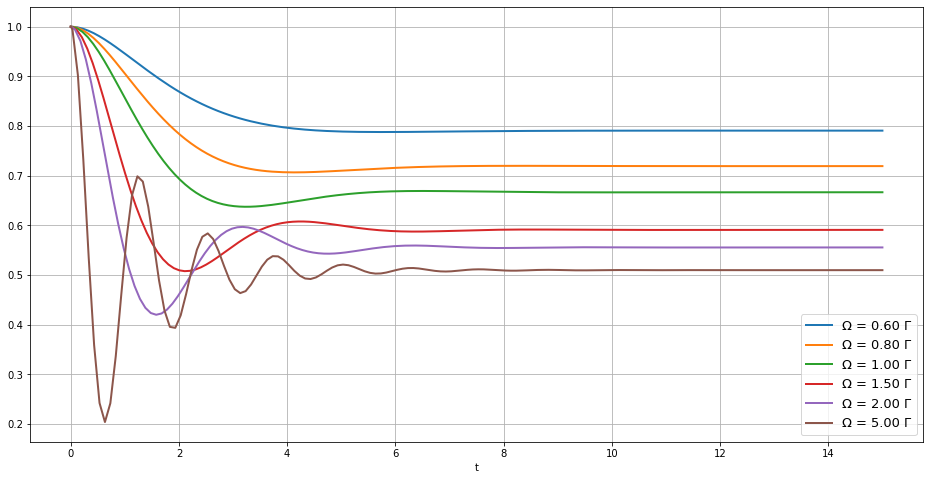

In [2285]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,15)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.6, 0.8, 1.0, 1.5, 2.0, 5.0]:
    replacements = [(δ, 0), (ga, 1), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

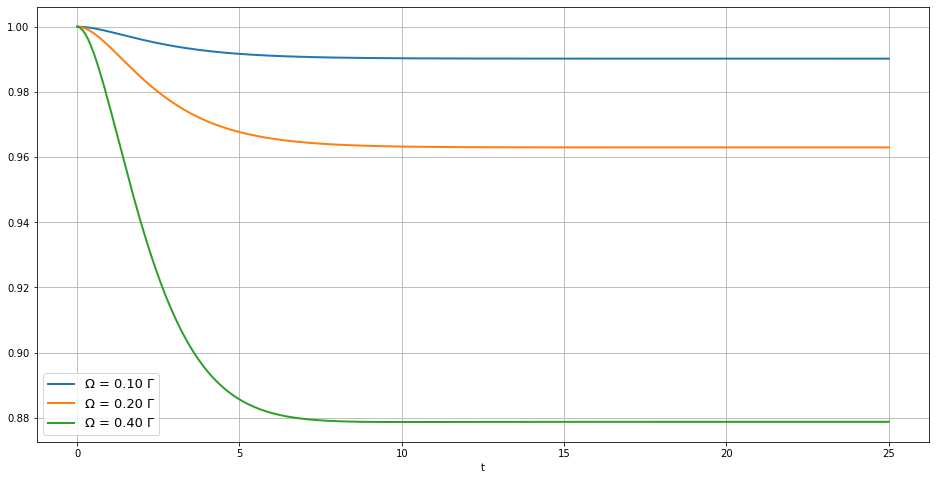

In [2286]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,25)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.1, 0.2, 0.4]:
    replacements = [(δ, 0), (ga, 1), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

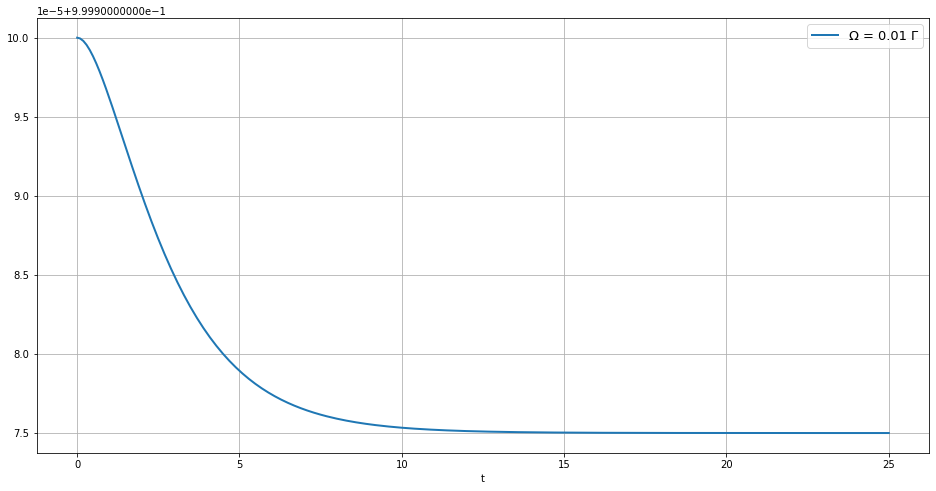

In [2287]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,25)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.005]:
    replacements = [(δ, 0), (ga, 1), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

In [2421]:
dis_nc = DissipatorNoConjugate(ham.levels)
dis_nc.addDecay(1,0,ga)

bloch_nc = BlochEquations(ham.levels, dis_nc.density_matrix, ham.transformed, dis_nc.dissipator)

In [2422]:
bloch_nc.hamiltonian.free_symbols

{Ω_a, δ}

In [2423]:
from itertools import product
from sympy.solvers.ode.systems import dsolve_system

eqns = [
    Eq(bloch_nc.equations.lhs[idx,idy], bloch_nc.equations.rhs[idx,idy]) 
    for idx,idy in product(range(ham.levels),range(ham.levels))
]
funcs = [
    bloch_nc.density_matrix[idx,idy] for idx,idy in product(range(ham.levels),range(ham.levels))
]
ics = {
    type(bloch_nc.density_matrix[idx,idy])(0): 0 for idx,idy in product(range(ham.levels),range(ham.levels))
}
ics[type(bloch_nc.density_matrix[0,0])(0)] = 1.0 

In [2424]:
eqns = [eq.subs(δ,0) for eq in eqns]
eqns

[Eq(Derivative(ρ₀₀(t), t), Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(-ρ₀₁(t) + ρ₁₀(t))),
 Eq(Derivative(ρ₀₁(t), t), -Γ_a*ρ₀₁(t)/2 + I*(-Ω_a*ρ₀₀(t) + Ω_a*ρ₁₁(t))/2),
 Eq(Derivative(ρ₁₀(t), t), -Γ_a*ρ₁₀(t)/2 - I*(-1.0*Ω_a*ρ₀₀(t) + 1.0*Ω_a*ρ₁₁(t))/2),
 Eq(Derivative(ρ₁₁(t), t), -Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(ρ₀₁(t) - ρ₁₀(t)))]

In [2425]:
sol = dsolve_system(eqns, funcs = funcs, ics = ics)

In [2426]:
sol[0][0].rhs.subs(ga,1).free_symbols

{t, Ω_a}

In [2427]:
# for s in sol[0]:
#     display(s.lhs)
#     display(s.rhs)
#     print("="*50)

Text(0.5, 0, 't [1/Γ]')

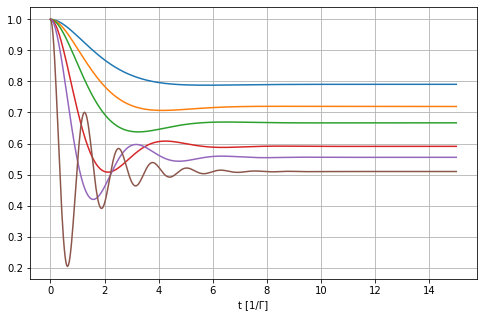

In [2428]:
_A_func = sympy.lambdify([t, WA], sol[0][0].subs(ga,1).rhs, modules = ['numpy', 'scipy'])
A_func = lambda t,Ω: _A_func(t+0j, Ω+0j).real

ts = np.linspace(0,15,501)
Ωs = np.linspace

fig, ax = plt.subplots(figsize = (8,5))

for Ωi in [0.6, 0.8, 1.0, 1.5, 2.0, 5.0]:
    ax.plot(ts, A_func(ts+0j, Ωi+0j))
    ax.grid(True)
ax.set_xlabel("t [1/Γ]")

## Add extra decay to non-interacting state (not included in levels)

In [2403]:
import copy

bloch_nc_ed = copy.deepcopy(bloch_nc)
gc = sympy.Symbol("Γ_c", real = True)
eqs = sympy.Matrix(bloch_nc_ed.equations.rhs)
eqs[1,1] -= gc*bloch_nc_ed.density_matrix[1,1]
eqs[0,1] -= gc*bloch_nc_ed.density_matrix[0,1]/2
eqs[1,0] -= gc*bloch_nc_ed.density_matrix[1,0]/2
bloch_nc_ed.equations = sympy.Eq(bloch_nc_ed.equations.lhs, eqs) 
bloch_nc_ed.equations

Eq(Matrix([
[Derivative(ρ₀₀(t), t), Derivative(ρ₀₁(t), t)],
[Derivative(ρ₁₀(t), t), Derivative(ρ₁₁(t), t)]]), Matrix([
[                                           Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(-ρ₀₁(t) + ρ₁₀(t)), -Γ_a*ρ₀₁(t)/2 - Γ_c*ρ₀₁(t)/2 + I*(-Ω_a*ρ₀₀(t) + Ω_a*ρ₁₁(t) + 2.0*δ*ρ₀₁(t))/2],
[-Γ_a*ρ₁₀(t)/2 - Γ_c*ρ₁₀(t)/2 - I*(-1.0*Ω_a*ρ₀₀(t) + 1.0*Ω_a*ρ₁₁(t) + 2.0*δ*ρ₁₀(t))/2,                       -Γ_a*ρ₁₁(t) - Γ_c*ρ₁₁(t) + 0.5*I*Ω_a*(ρ₀₁(t) - ρ₁₀(t))]]))

In [2404]:
bloch_nc_ed.hamiltonian

Matrix([
[-1.0*δ, -Ω_a/2],
[-Ω_a/2,      0]])

In [2405]:
bloch_nc.equations

Eq(Matrix([
[Derivative(ρ₀₀(t), t), Derivative(ρ₀₁(t), t)],
[Derivative(ρ₁₀(t), t), Derivative(ρ₁₁(t), t)]]), Matrix([
[                            Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(-ρ₀₁(t) + ρ₁₀(t)), -Γ_a*ρ₀₁(t)/2 + I*(-Ω_a*ρ₀₀(t) + Ω_a*ρ₁₁(t) + 2.0*δ*ρ₀₁(t))/2],
[-Γ_a*ρ₁₀(t)/2 - I*(-1.0*Ω_a*ρ₀₀(t) + 1.0*Ω_a*ρ₁₁(t) + 2.0*δ*ρ₁₀(t))/2,                     -Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(ρ₀₁(t) - ρ₁₀(t))]]))

In [2406]:
bloch_nc_ed.equations.subs(gc, 0)

Eq(Matrix([
[Derivative(ρ₀₀(t), t), Derivative(ρ₀₁(t), t)],
[Derivative(ρ₁₀(t), t), Derivative(ρ₁₁(t), t)]]), Matrix([
[                            Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(-ρ₀₁(t) + ρ₁₀(t)), -Γ_a*ρ₀₁(t)/2 + I*(-Ω_a*ρ₀₀(t) + Ω_a*ρ₁₁(t) + 2.0*δ*ρ₀₁(t))/2],
[-Γ_a*ρ₁₀(t)/2 - I*(-1.0*Ω_a*ρ₀₀(t) + 1.0*Ω_a*ρ₁₁(t) + 2.0*δ*ρ₁₀(t))/2,                     -Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(ρ₀₁(t) - ρ₁₀(t))]]))

In [2407]:
bloch.equations

Eq(Matrix([
[           Derivative(ρ₀₀(t), t), Derivative(ρ₀₁(t), t)],
[conjugate(Derivative(ρ₀₁(t), t)), Derivative(ρ₁₁(t), t)]]), Matrix([
[                                       Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(-ρ₀₁(t) + conjugate(ρ₀₁(t))), -Γ_a*ρ₀₁(t)/2 + I*(-Ω_a*ρ₀₀(t) + Ω_a*ρ₁₁(t) + 2.0*δ*ρ₀₁(t))/2],
[-Γ_a*conjugate(ρ₀₁(t))/2 - I*(-1.0*Ω_a*ρ₀₀(t) + 1.0*Ω_a*ρ₁₁(t) + 2.0*δ*conjugate(ρ₀₁(t)))/2,          -Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(ρ₀₁(t) - conjugate(ρ₀₁(t)))]]))

In [2408]:
from itertools import product
from sympy.solvers.ode.systems import dsolve_system

eqns = [
    Eq(bloch_nc_ed.equations.lhs[idx,idy], bloch_nc_ed.equations.rhs[idx,idy]) 
    for idx,idy in product(range(ham.levels),range(ham.levels))
]
funcs = [
    bloch_nc_ed.density_matrix[idx,idy] for idx,idy in product(range(ham.levels),range(ham.levels))
]
ics = {
    type(bloch_nc_ed.density_matrix[idx,idy])(0): 0 for idx,idy in product(range(ham.levels),range(ham.levels))
}
ics[type(bloch_nc_ed.density_matrix[0,0])(0)] = 1.0 

In [2410]:
eqns = [eq.subs(δ,0).subs(gc,0) for eq in eqns]
eqns

[Eq(Derivative(ρ₀₀(t), t), Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(-ρ₀₁(t) + ρ₁₀(t))),
 Eq(Derivative(ρ₀₁(t), t), -Γ_a*ρ₀₁(t)/2 + I*(-Ω_a*ρ₀₀(t) + Ω_a*ρ₁₁(t))/2),
 Eq(Derivative(ρ₁₀(t), t), -Γ_a*ρ₁₀(t)/2 - I*(-1.0*Ω_a*ρ₀₀(t) + 1.0*Ω_a*ρ₁₁(t))/2),
 Eq(Derivative(ρ₁₁(t), t), -Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(ρ₀₁(t) - ρ₁₀(t)))]

In [2411]:
sol = dsolve_system(eqns, funcs = funcs, ics = ics)

In [2412]:
_A_ed_func = sympy.lambdify([t, WA], sol[0][0].subs(ga,1).rhs, modules = ['numpy', 'scipy'])
A_ed_func = lambda t,Ω: _A_func(t+0j, Ω+0j).real

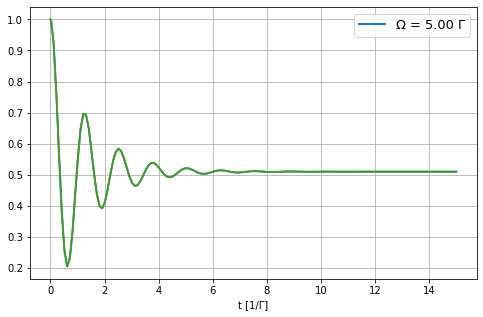

In [2415]:
y0 = np.zeros((bloch_nc_ed.levels,bloch_nc_ed.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,15)

fig, ax = plt.subplots(figsize = (8,5))

# somehow a sqrt(2) factor in the rabi rate??

for Ωi in [5]:
    replacements = [(δ, 0), (ga, 1-gc), (gc, 0), (WA, Ωi*np.sqrt(2))]
    sol = bloch_nc_ed.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
    ax.plot(x, A_func(x, Ωi))
    ax.plot(x, A_ed_func(x, Ωi))
ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

In [2417]:
from itertools import product
from sympy.solvers.ode.systems import dsolve_system

eqns = [
    Eq(bloch_nc_ed.equations.lhs[idx,idy], bloch_nc_ed.equations.rhs[idx,idy]) 
    for idx,idy in product(range(ham.levels),range(ham.levels))
]
funcs = [
    bloch_nc_ed.density_matrix[idx,idy] for idx,idy in product(range(ham.levels),range(ham.levels))
]
ics = {
    type(bloch_nc_ed.density_matrix[idx,idy])(0): 0 for idx,idy in product(range(ham.levels),range(ham.levels))
}
ics[type(bloch_nc_ed.density_matrix[0,0])(0)] = 1.0 

In [2418]:
eqns = [eq.subs(δ,0) for eq in eqns]
eqns

[Eq(Derivative(ρ₀₀(t), t), Γ_a*ρ₁₁(t) + 0.5*I*Ω_a*(-ρ₀₁(t) + ρ₁₀(t))),
 Eq(Derivative(ρ₀₁(t), t), -Γ_a*ρ₀₁(t)/2 - Γ_c*ρ₀₁(t)/2 + I*(-Ω_a*ρ₀₀(t) + Ω_a*ρ₁₁(t))/2),
 Eq(Derivative(ρ₁₀(t), t), -Γ_a*ρ₁₀(t)/2 - Γ_c*ρ₁₀(t)/2 - I*(-1.0*Ω_a*ρ₀₀(t) + 1.0*Ω_a*ρ₁₁(t))/2),
 Eq(Derivative(ρ₁₁(t), t), -Γ_a*ρ₁₁(t) - Γ_c*ρ₁₁(t) + 0.5*I*Ω_a*(ρ₀₁(t) - ρ₁₀(t)))]

In [2429]:
# takes too long to solve
# sol = dsolve_system(eqns, funcs = funcs, ics = ics)

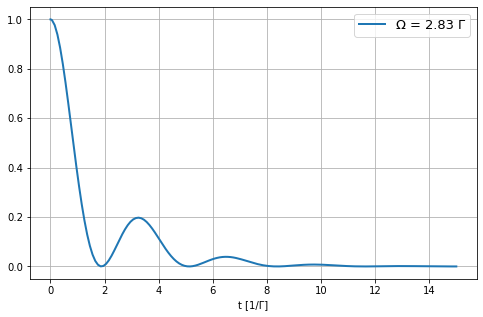

In [2416]:
y0 = np.zeros((bloch_nc_ed.levels,bloch_nc_ed.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,15)

fig, ax = plt.subplots(figsize = (8,5))

# somehow a sqrt(2) factor in the rabi rate??

for Ωi in [2]:
    replacements = [(δ, 0), (ga, 1-gc), (gc, 1), (WA, Ωi*np.sqrt(2))]
    sol = bloch_nc_ed.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

# 3 level system with single drive and decay to third state

In [2430]:
A = Symbol(u'A', real = True)
B = Symbol(u'B', real = True)
E = Symbol(u'E', real = True)

δ = Symbol(u'δ', real = True)

gc = Symbol(u'Γ_c', real = True)


wA = Symbol(u'ω_a', real = True)
WA = Symbol(u'Ω_a', real = True)
ham = Hamiltonian(3)

ham.addEnergies([A, B, E])
ham.addCoupling(0,2,WA,wA)

ham.eqnTransform()
ham.defineZero(E)
ham.defineStateDetuning(0,2,δ)

dis = Dissipator(ham.levels)
dis.addDecay(2,1,gc)

bloch = BlochEquations(dis.levels, dis.density_matrix, ham.transformed, dis.dissipator)

In [2431]:
from scipy.optimize import curve_fit

def exp_decay(t, A, λ):
    return A*np.exp(-t/λ)

def rabi_flop(t, Ω):
    return np.sin(Ω*t/2)**2

def exp_accumulate(t, A, λ):
    return 1-np.exp(-t/λ)

In [2432]:
bloch.hamiltonian

Matrix([
[-1.0*δ, 0, -Ω_a/2],
[     0, B,      0],
[-Ω_a/2, 0,      0]])

In [2433]:
bloch.dissipator

Matrix([
[                       0,                        0, -Γ_c*ρ₀₂(t)/2],
[                       0,               Γ_c*ρ₂₂(t), -Γ_c*ρ₁₂(t)/2],
[-Γ_c*conjugate(ρ₀₂(t))/2, -Γ_c*conjugate(ρ₁₂(t))/2,   -Γ_c*ρ₂₂(t)]])

In [2434]:
bloch.equations.rhs

Matrix([
[                                                    0.5*I*Ω_a*(-ρ₀₂(t) + conjugate(ρ₀₂(t))),         I*(1.0*B*ρ₀₁(t) + 0.5*Ω_a*conjugate(ρ₁₂(t)) + 1.0*δ*ρ₀₁(t)),  -Γ_c*ρ₀₂(t)/2 + I*(-Ω_a*ρ₀₀(t) + Ω_a*ρ₂₂(t) + 2.0*δ*ρ₀₂(t))/2],
[                    I*(-1.0*B*conjugate(ρ₀₁(t)) - 0.5*Ω_a*ρ₁₂(t) - 1.0*δ*conjugate(ρ₀₁(t))),                                                          Γ_c*ρ₂₂(t), -Γ_c*ρ₁₂(t)/2 - I*(2.0*B*ρ₁₂(t) + 1.0*Ω_a*conjugate(ρ₀₁(t)))/2],
[-Γ_c*conjugate(ρ₀₂(t))/2 - I*(-1.0*Ω_a*ρ₀₀(t) + 1.0*Ω_a*ρ₂₂(t) + 2.0*δ*conjugate(ρ₀₂(t)))/2, -Γ_c*conjugate(ρ₁₂(t))/2 + I*(2*B*conjugate(ρ₁₂(t)) + Ω_a*ρ₀₁(t))/2,           -Γ_c*ρ₂₂(t) + 0.5*I*Ω_a*(ρ₀₂(t) - conjugate(ρ₀₂(t)))]])

Ω = 0.71 Γ -> λ = 1.05
Ω = 0.80 Γ -> λ = 0.61
Ω = 1.00 Γ -> λ = 5.33
Ω = 2.00 Γ -> λ = 3.52
Ω = 50.00 Γ -> λ = 1.92


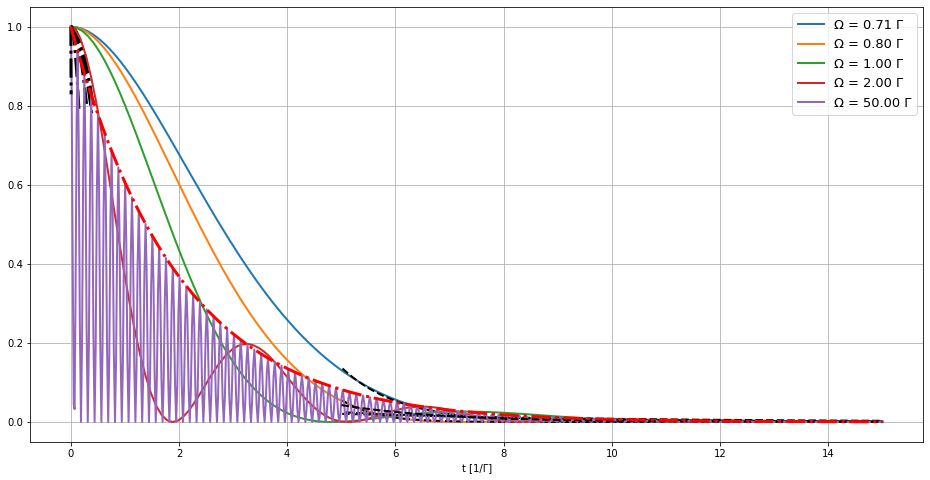

In [2435]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,15)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [1/np.sqrt(2), 0.8, 1.0, 2.0, 50.0]:
    replacements = [(δ, 0), (gc, 1), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 5
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
    m = x < 1/Ωi
    ax.plot(x[m]/(np.pi), 1-rabi_flop(x[m], Ωi), '-.k', lw = 3)
    
# ax.set_yscale('log')

ax.plot(x, np.exp(-x/2), ls = '-.', color = 'r', lw = 3)

ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

λ = 2.00


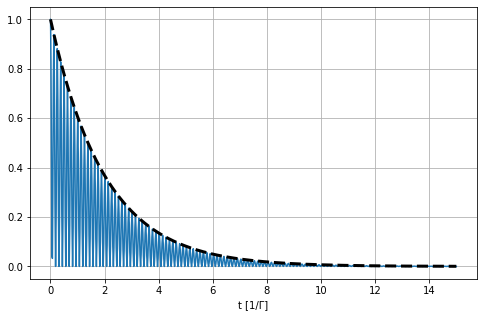

In [2436]:
from scipy import signal
peaks = signal.find_peaks(y[0])

_x, _y =  x[peaks[0]], y[0,peaks[0]]
m = x > 5
popt, pcov = curve_fit(exp_decay, _x, _y, p0 = [1, 20])
    
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, y[0])
ax.plot(x, exp_decay(x, *popt), lw = 3, color = 'k', ls = '--')
ax.grid(True)
ax.set_xlabel("t [1/Γ]")

print(f"λ = {popt[1]:.2f}")

Ω = 0.10 Γ -> λ = 99.01
Ω = 0.20 Γ -> λ = 24.01
Ω = 0.40 Γ -> λ = 5.29


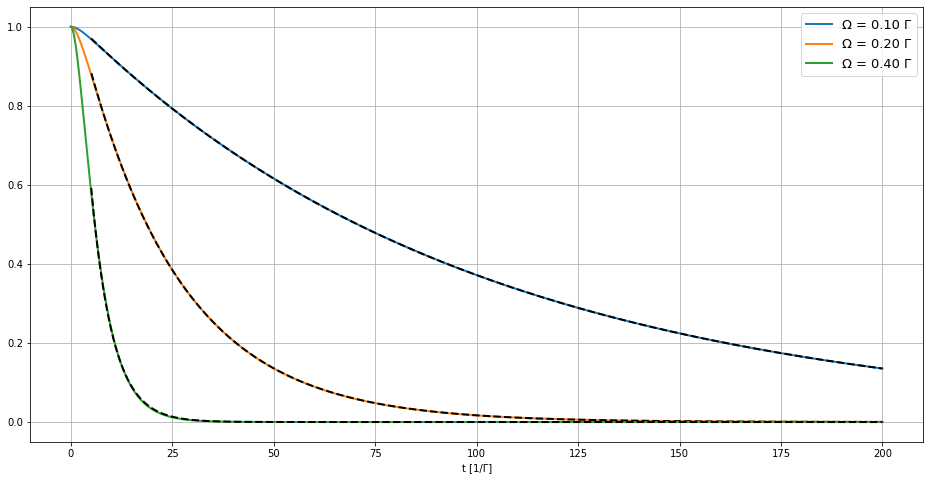

In [2437]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,200)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.1, 0.2, 0.4]:
    replacements = [(δ, 0), (gc, 1), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 5
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
# ax.set_yscale('log')

ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 0.01 Γ -> λ = 9999.02
Ω = 0.05 Γ -> λ = 399.00


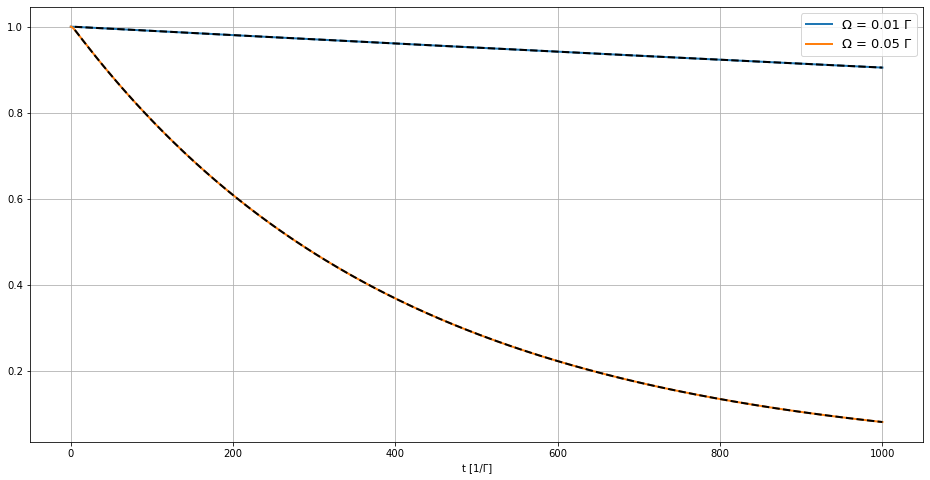

In [2438]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,1000)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.01, 0.05]:
    replacements = [(δ, 0), (gc, 1), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 5
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
# ax.set_yscale('log')

ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 50.00 Γ -> λ = 2.00


C:\Users\ogras\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


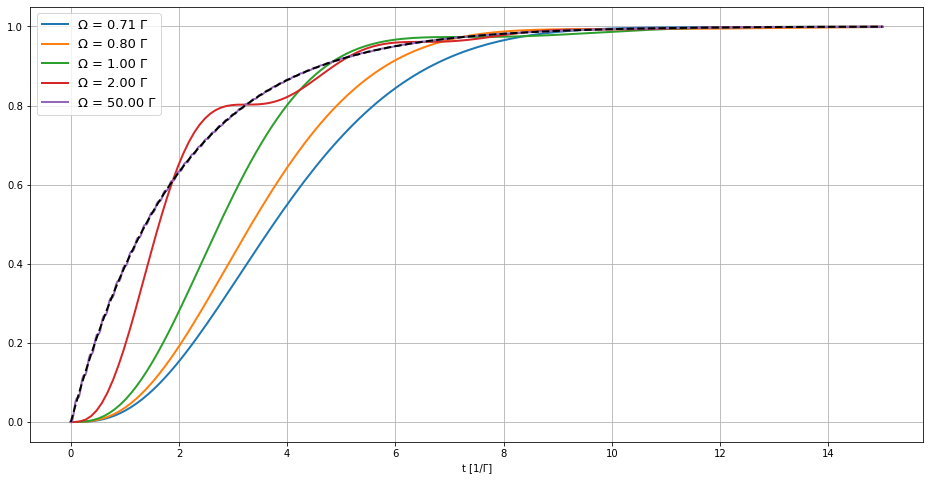

In [2439]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,15)

fig, ax = plt.subplots(figsize = (16,8))

id_states = 1

for Ωi in [1/np.sqrt(2), 0.8, 1.0, 2.0, 50.0]:
    replacements = [(δ, 0), (gc, 1), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[id_states,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    
m = x > 0
xf, yf = x[m], y[id_states,m]
popt, pcov = curve_fit(exp_accumulate, xf, yf, p0 = [1, 2])

ax.plot(xf, exp_accumulate(xf, *popt), '--k', lw = 2)
print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
# ax.set_yscale('log')

ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

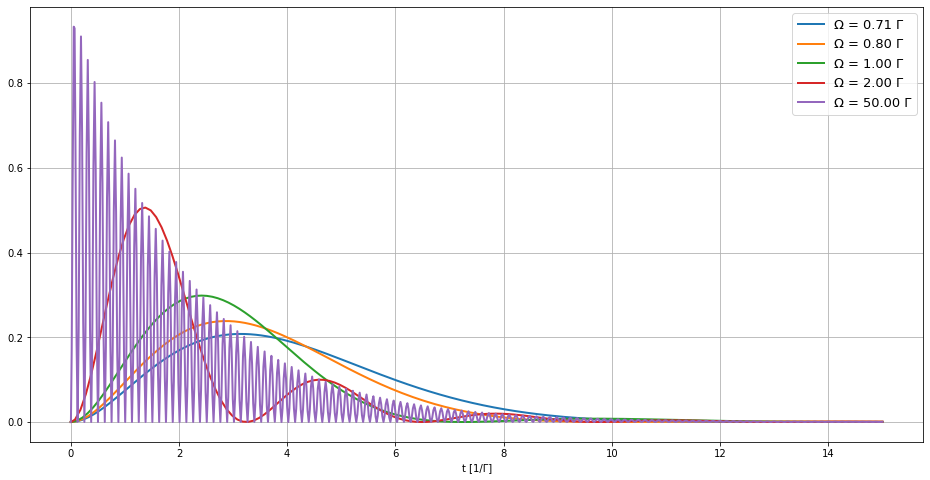

In [2440]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,15)

fig, ax = plt.subplots(figsize = (16,8))

id_states = 2

for Ωi in [1/np.sqrt(2), 0.8, 1.0, 2.0, 50.0]:
    replacements = [(δ, 0), (gc, 1), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[id_states,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    

# ax.set_yscale('log')

ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

λ = 2.00


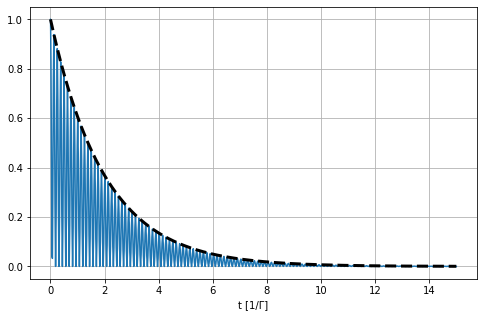

In [2441]:
from scipy import signal
peaks = signal.find_peaks(y[0])

_x, _y =  x[peaks[0]], y[0,peaks[0]]
m = x > 5
popt, pcov = curve_fit(exp_decay, _x, _y, p0 = [1, 20])
    
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, y[0])
ax.plot(x, exp_decay(x, *popt), lw = 3, color = 'k', ls = '--')
ax.grid(True)
ax.set_xlabel("t [1/Γ]")

print(f"λ = {popt[1]:.2f}")

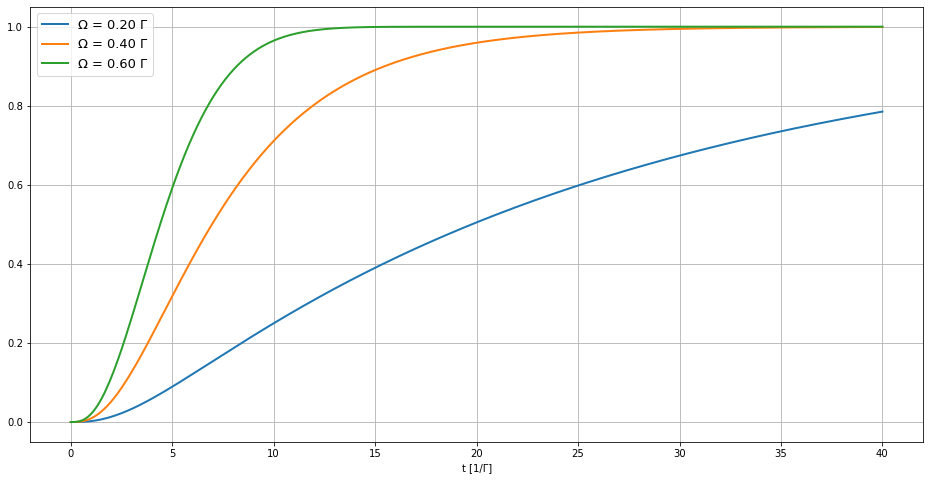

In [2442]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,40)

id_states = 1

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.2, 0.4, 0.6]:
    replacements = [(δ, 0), (gc, 1), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[id_states,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
    
# ax.set_yscale('log')

ax.set_xlabel('t [1/π]')
ax.legend(fontsize = 13)
ax.set_xlabel("t [1/Γ]")
ax.grid(True)

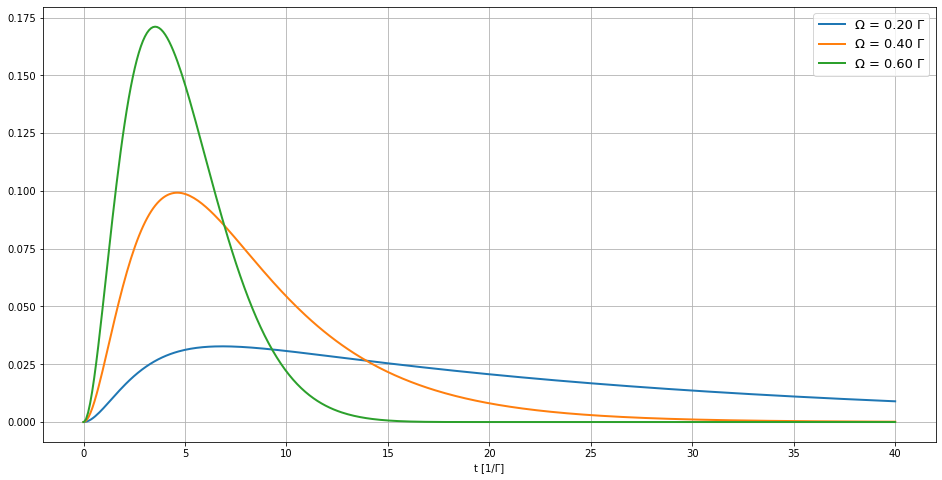

In [2443]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,40)

id_states = 2

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.2, 0.4, 0.6]:
    replacements = [(δ, 0), (gc, 1), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[id_states,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
    
# ax.set_yscale('log')

ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

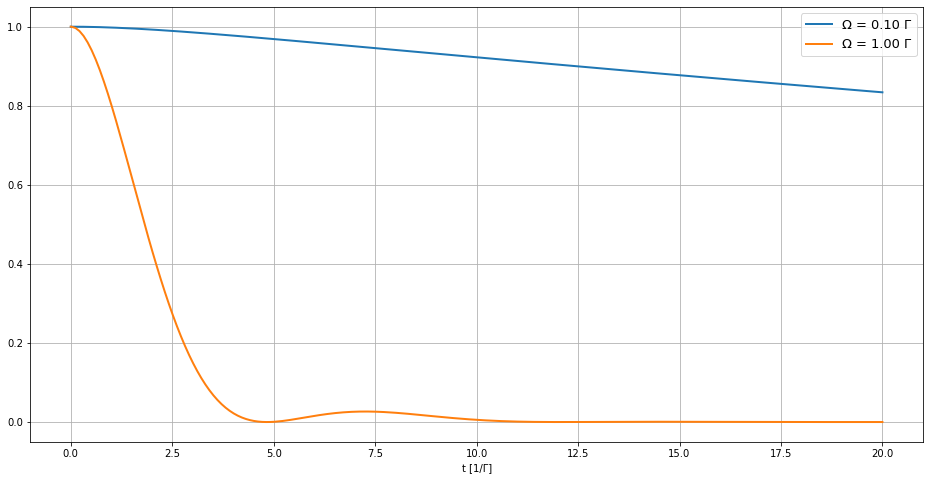

In [2444]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,20)

id_states = 0

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.1, 1]:
    replacements = [(δ, 0), (gc, 1), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[id_states,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
    
# ax.set_yscale('log')

ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

In [1347]:
dis_nd = DissipatorNoConjugate(ham.levels)
dis_nd.addDecay(2,0,ga)
dis_nd.addDecay(2,1,gb)

bloch_nd = BlochEquations(ham.levels, dis_nd.density_matrix, ham.transformed, dis_nd.dissipator)

In [1355]:
from itertools import product
from sympy.solvers.ode.systems import dsolve_system

eqns = [
    Eq(bloch_nd.equations.lhs[idx,idy], bloch_nd.equations.rhs[idx,idy]) 
    for idx,idy in product(range(ham.levels),range(ham.levels))
]
funcs = [
    bloch_nd.density_matrix[idx,idy] for idx,idy in product(range(ham.levels),range(ham.levels))
]
ics = {
    type(bloch_nd.density_matrix[idx,idy])(0): 0 for idx,idy in product(range(ham.levels),range(ham.levels))
}
ics[type(bloch_nd.density_matrix[0,0])(0)] = 1.0 

In [1356]:
eqns = [eq.subs(δ,0) for eq in eqns]
eqns

[Eq(Derivative(ρ₀₀(t), t), Γ_a*ρ₂₂(t) + 0.5*I*Ω_a*(-ρ₀₂(t) + ρ₂₀(t))),
 Eq(Derivative(ρ₀₁(t), t), I*(1.0*B*ρ₀₁(t) + 0.5*Ω_a*ρ₂₁(t))),
 Eq(Derivative(ρ₀₂(t), t), -(Γ_a + Γ_b)*ρ₀₂(t)/2 + I*(-Ω_a*ρ₀₀(t) + Ω_a*ρ₂₂(t))/2),
 Eq(Derivative(ρ₁₀(t), t), I*(-1.0*B*ρ₁₀(t) - 0.5*Ω_a*ρ₁₂(t))),
 Eq(Derivative(ρ₁₁(t), t), Γ_b*ρ₂₂(t)),
 Eq(Derivative(ρ₁₂(t), t), -(Γ_a + Γ_b)*ρ₁₂(t)/2 - I*(2.0*B*ρ₁₂(t) + 1.0*Ω_a*ρ₁₀(t))/2),
 Eq(Derivative(ρ₂₀(t), t), -(Γ_a + Γ_b)*ρ₂₀(t)/2 - I*(-1.0*Ω_a*ρ₀₀(t) + 1.0*Ω_a*ρ₂₂(t))/2),
 Eq(Derivative(ρ₂₁(t), t), -(Γ_a + Γ_b)*ρ₂₁(t)/2 + I*(2*B*ρ₂₁(t) + Ω_a*ρ₀₁(t))/2),
 Eq(Derivative(ρ₂₂(t), t), 0.5*I*Ω_a*(ρ₀₂(t) - ρ₂₀(t)) - (Γ_a + Γ_b)*ρ₂₂(t))]

In [2445]:
# takes too long to solve
# sol = dsolve_system(eqns, funcs = funcs, ics = ics)

# 3 level system with single drive and decay to 2 states

In [2136]:
A = Symbol(u'A', real = True)
B = Symbol(u'B', real = True)
E = Symbol(u'E', real = True)

δ = Symbol(u'δ', real = True)

ga = Symbol(u'Γ_a', real = True)
gb = Symbol(u'Γ_b', real = True)


wA = Symbol(u'ω_a', real = True)
WA = Symbol(u'Ω_a', real = True)
ham = Hamiltonian(3)

ham.addEnergies([A, B, E])
ham.addCoupling(0,2,WA,wA)

ham.eqnTransform()
ham.defineZero(E)
ham.defineStateDetuning(0,2,δ)

dis = Dissipator(ham.levels)
dis.addDecay(2,0,ga)
dis.addDecay(2,1,gb)

bloch = BlochEquations(dis.levels, dis.density_matrix, ham.transformed, dis.dissipator)

In [2137]:
from scipy.optimize import curve_fit

def exp_decay(t, A, λ):
    return A*np.exp(-t/λ)

def rabi_flop(t, Ω):
    return np.sin(Ω*t/2)**2

def exp_accumulate(t, A, λ):
    return 1-np.exp(-t/λ)

In [2138]:
dis.density_matrix

Matrix([
[           ρ₀₀(t),            ρ₀₁(t), ρ₀₂(t)],
[conjugate(ρ₀₁(t)),            ρ₁₁(t), ρ₁₂(t)],
[conjugate(ρ₀₂(t)), conjugate(ρ₁₂(t)), ρ₂₂(t)]])

In [2139]:
bloch.hamiltonian

Matrix([
[-1.0*δ, 0, -Ω_a/2],
[     0, B,      0],
[-Ω_a/2, 0,      0]])

In [2140]:
bloch.dissipator

Matrix([
[                      Γ_a*ρ₂₂(t),                                0, (-Γ_a - Γ_b)*ρ₀₂(t)/2],
[                               0,                       Γ_b*ρ₂₂(t), (-Γ_a - Γ_b)*ρ₁₂(t)/2],
[(-Γ_a - Γ_b)*conjugate(ρ₀₂(t))/2, (-Γ_a - Γ_b)*conjugate(ρ₁₂(t))/2,   (-Γ_a - Γ_b)*ρ₂₂(t)]])

Ω = 0.71 Γ -> λ = 6.34
Ω = 0.80 Γ -> λ = 5.78
Ω = 1.00 Γ -> λ = 5.05
Ω = 2.00 Γ -> λ = 4.35
Ω = 50.00 Γ -> λ = 3.99


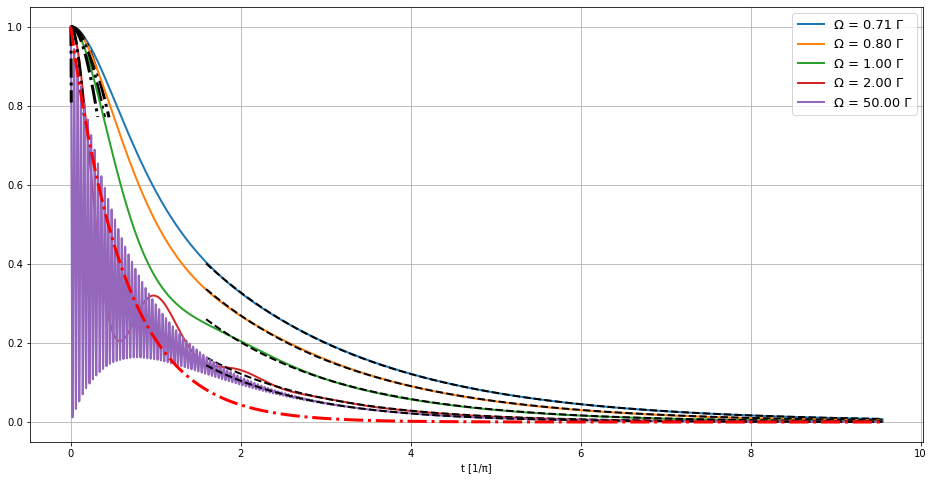

In [2141]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,30)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [1/np.sqrt(2), 0.8, 1.0, 2.0, 50.0]:
    replacements = [(δ, 0), (ga, 0.5), (gb, 0.5), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0, max_step = 5e-3)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x/(np.pi), y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 5
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf/(np.pi), exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
    m = x < 1/Ωi
    ax.plot(x[m]/(np.pi), 1-rabi_flop(x[m], Ωi), '-.k', lw = 3)
    
# ax.set_yscale('log')

ax.plot(x/np.pi, np.exp(-x/2), ls = '-.', color = 'r', lw = 3)

ax.set_xlabel('t [1/π]')
ax.legend(fontsize = 13)
ax.grid(True)

λ = 2.84


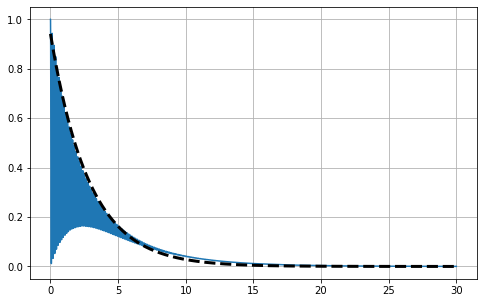

In [2142]:
from scipy import signal
peaks = signal.find_peaks(y[0])

_x, _y =  x[peaks[0]], y[0,peaks[0]]
m = x > 5
popt, pcov = curve_fit(exp_decay, _x, _y, p0 = [1, 20])
    
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, y[0])
ax.plot(x, exp_decay(x, *popt), lw = 3, color = 'k', ls = '--')
ax.grid(True)

print(f"λ = {popt[1]:.2f}")

Ω = 0.10 Γ -> λ = 201.02
Ω = 0.20 Γ -> λ = 51.10
Ω = 0.40 Γ -> λ = 13.91
Ω = 0.50 Γ -> λ = 9.65


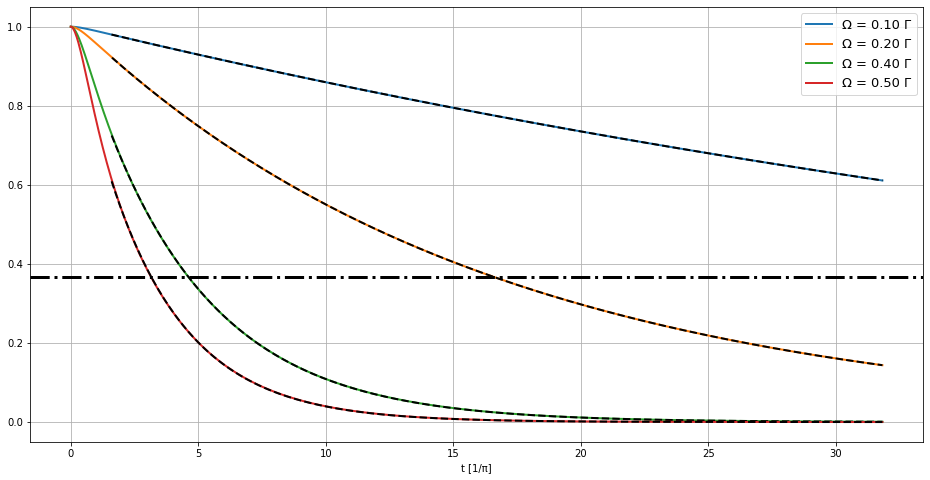

In [2143]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,100)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.1, 0.2, 0.4, 0.5]:
    replacements = [(δ, 0), (ga, 0.5), (gb, 0.5), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x/(np.pi), y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 5
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf/(np.pi), exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")

ax.axhline(np.exp(-1), color = 'k', ls = '-.', lw = 3)
ax.set_xlabel('t [1/π]')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 0.01 Γ -> λ = 20001.00
Ω = 0.05 Γ -> λ = 801.01


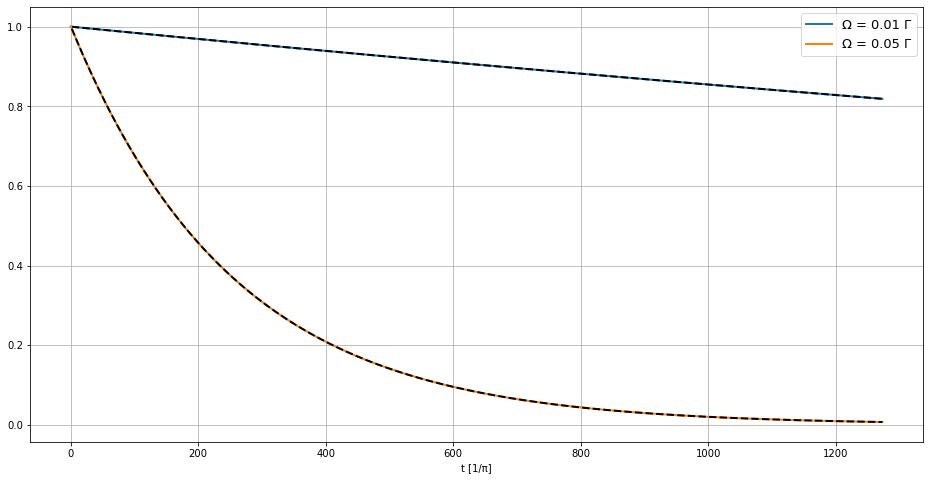

In [2144]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,4000)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.01, 0.05]:
    replacements = [(δ, 0), (ga, 0.5), (gb, 0.5), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x/(np.pi), y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 5
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf/(np.pi), exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")

ax.set_xlabel('t [1/π]')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 0.00 Γ -> λ = 2000001.00


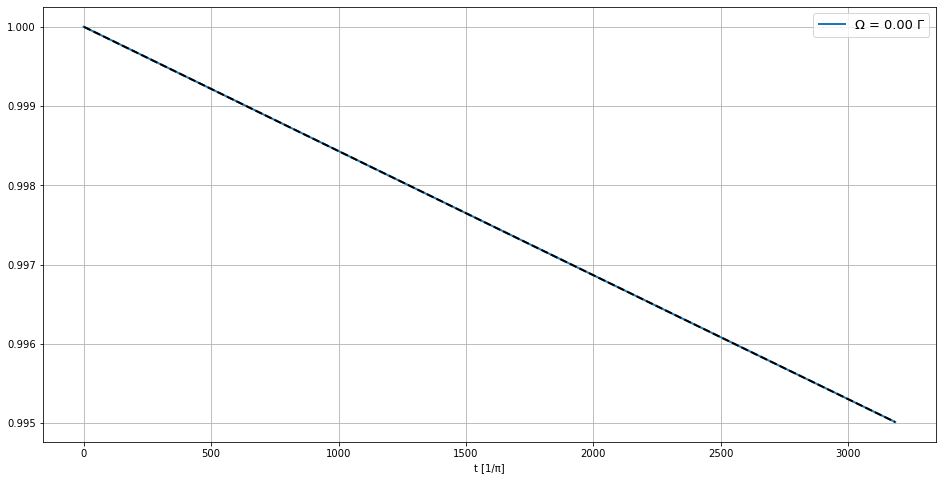

In [2145]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,10000)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.001]:
    replacements = [(δ, 0), (ga, 0.5), (gb, 0.5), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0, max_step = 1)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x/(np.pi), y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 5
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf/(np.pi), exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")

ax.set_xlabel('t [1/π]')
ax.legend(fontsize = 13)
ax.grid(True)

In [2146]:
from joblib import delayed, Parallel

y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,100)

def run_func(Ωi, Γa):
    replacements = [(δ, 0), (ga, Γa), (gb, (1-Γa)), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    m = x > 5
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    return (Ωi, Γa, popt)
    

popt_list = Parallel(n_jobs=4, verbose = 1)(delayed(run_func)(Ωi, Γa) 
    for Ωi, Γa in product(np.linspace(0.1,2,101), np.linspace(0,0.9,19))
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   39.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 1919 out of 1919 | elapsed:  2.7min finished


In [2147]:
def generate_meshgrid_from_xyz(x,y,z):
    x_uni, x_idx = np.unique(x, return_inverse = True)
    y_uni, y_idx = np.unique(y, return_inverse = True)
    
    Z = np.empty(x_uni.shape + y_uni.shape)
    Z.fill(np.nan)
    Z[x_idx, y_idx] = z
    
    Y,X = np.meshgrid(y_uni, x_uni)
    
    return X,Y,Z

In [2148]:
x,y,z = list(zip(*popt_list))
x = np.array(x)
y = np.array(y)
z = np.array(z)
X,Y,Z = generate_meshgrid_from_xyz(x,y,z[:,1])

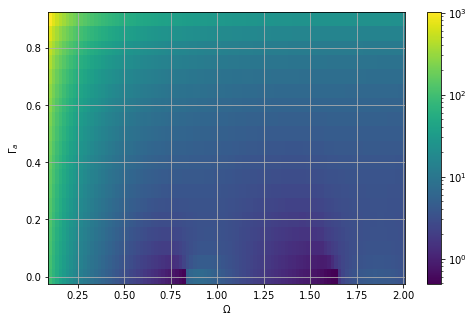

In [2149]:
from matplotlib import colors

fig, ax = plt.subplots(figsize = (8,5))
c = ax.pcolormesh(X,Y,Z,norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))
cbar = fig.colorbar(c)
ax.set_xlabel('Ω')
ax.set_ylabel('Γ$_a$')
ax.grid(True)

Ω = 0.80 Γ -> λ = 1.25
Ω = 1.00 Γ -> λ = 0.72
Ω = 5.00 Γ -> λ = 1.37


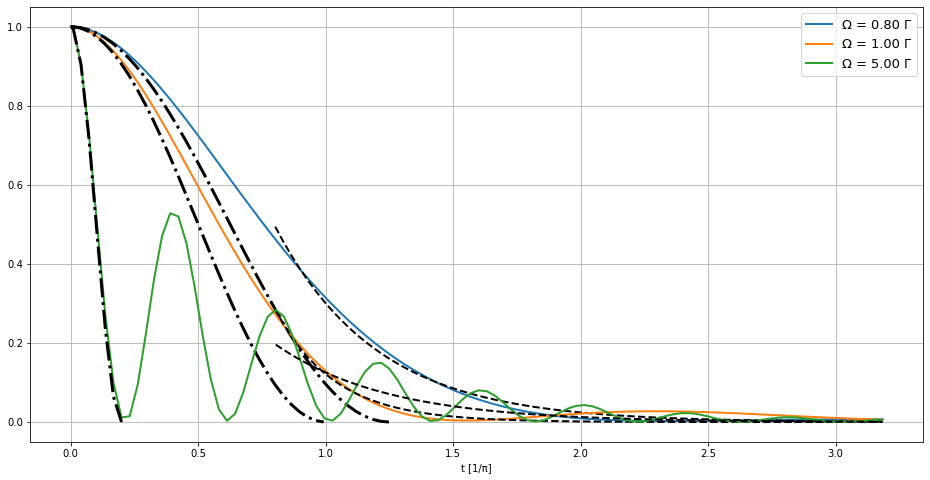

In [2150]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

id_state = 0

tspan = (0,10)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.8,1,5]:
    replacements = [(δ, 0), (ga, 0.01), (gb, 0.99), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x/(np.pi), y[id_state,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 2.5
    xf, yf = x[m], y[id_state,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf/(np.pi), exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")

    m = x < np.pi/Ωi
    ax.plot(x[m]/(np.pi), 1-rabi_flop(x[m], Ωi), '-.k', lw = 3)

ax.set_xlabel('t [1/π]')
ax.legend(fontsize = 13)
ax.grid(True)

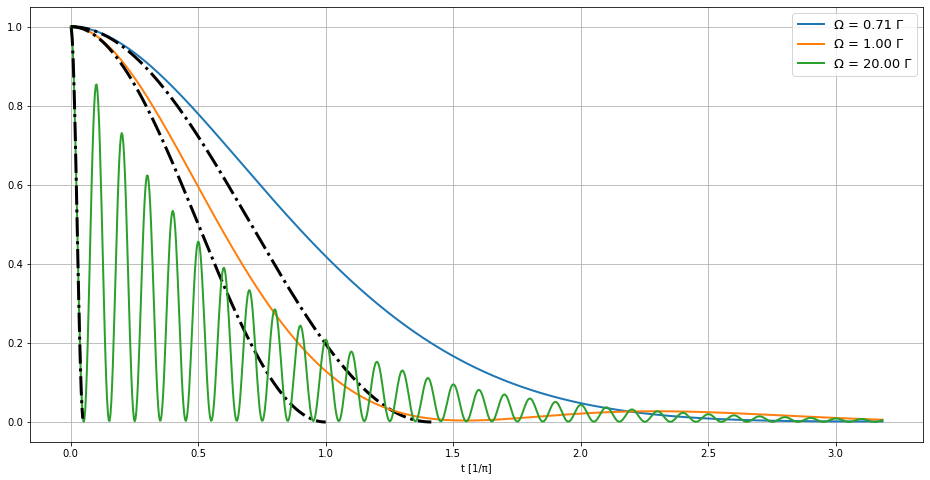

In [2151]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

id_state = 0

tspan = (0,10)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [1/np.sqrt(2),1,20]:
    replacements = [(δ, 0), (ga, 0.01), (gb, 0.99), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0, max_step = 1e-2)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x/(np.pi), y[id_state,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')

    m = x < np.pi/Ωi
    ax.plot(x[m]/(np.pi), 1-rabi_flop(x[m], Ωi), '-.k', lw = 3)

ax.set_xlabel('t [1/π]')
ax.legend(fontsize = 13)
ax.grid(True)

λ = 2.00


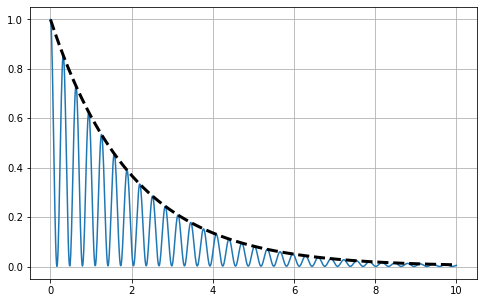

In [2152]:
from scipy import signal
peaks = signal.find_peaks(y[0])

_x, _y =  x[peaks[0]], y[0,peaks[0]]
m = x > 5
popt, pcov = curve_fit(exp_decay, _x, _y, p0 = [1, 20])
    
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, y[0])
ax.plot(x, exp_decay(x, *popt), lw = 3, color = 'k', ls = '--')
ax.grid(True)

print(f"λ = {popt[1]:.2f}")

Ω = 0.80 Γ -> λ = 10.47
Ω = 1.00 Γ -> λ = 8.96
Ω = 5.00 Γ -> λ = 6.76


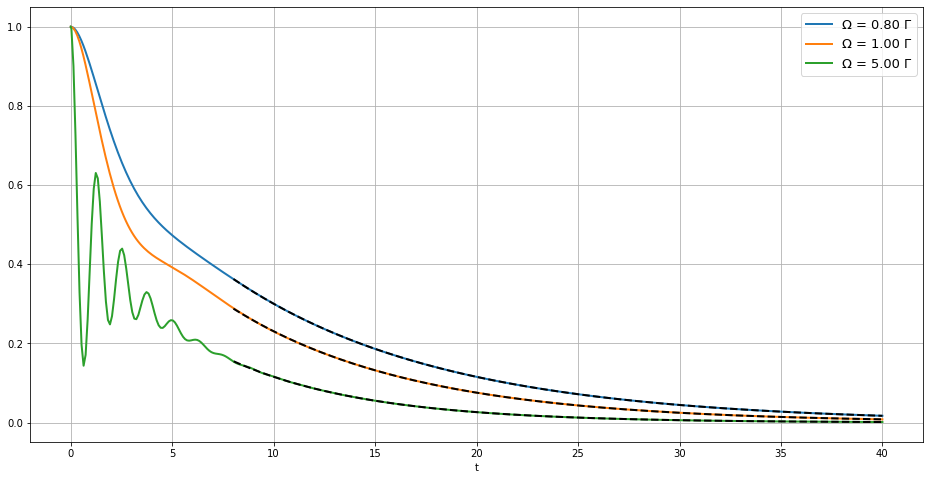

In [2153]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

id_state = 0

tspan = (0,40)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.8,1,5]:
    replacements = [(δ, 0), (ga, 0.7), (gb, 0.3), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[id_state,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 8
    xf, yf = x[m], y[id_state,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")

ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 1.00 Γ -> λ = 8.96
Ω = 10.00 Γ -> λ = 6.68


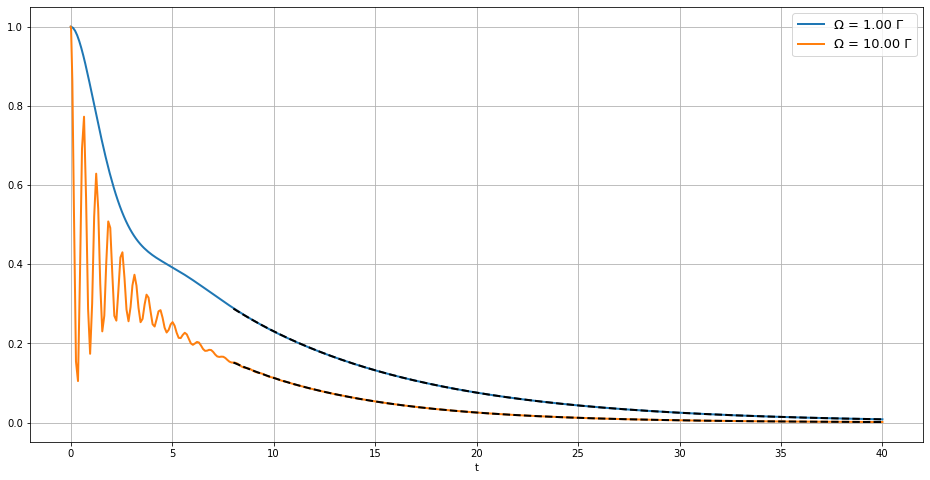

In [2154]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

id_state = 0

tspan = (0,40)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [1,10]:
    replacements = [(δ, 0), (ga, 0.7), (gb, 0.3), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[id_state,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 8
    xf, yf = x[m], y[id_state,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")

ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 0.10 Γ -> λ = 337.04
Ω = 0.20 Γ -> λ = 87.15


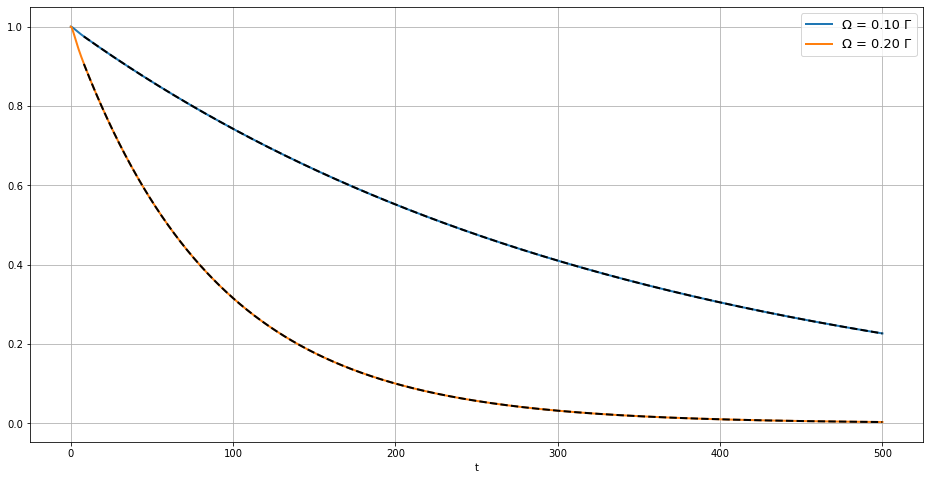

In [2155]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

id_state = 0

tspan = (0,500)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.1, 0.2]:
    replacements = [(δ, 0), (ga, 0.7), (gb, 0.3), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[id_state,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 8
    xf, yf = x[m], y[id_state,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")

ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 0.80 Γ -> λ = 354.93
Ω = 1.00 Γ -> λ = 299.00
Ω = 5.00 Γ -> λ = 203.94
Ω = 10.00 Γ -> λ = 200.98
Ω = 20.00 Γ -> λ = 200.25


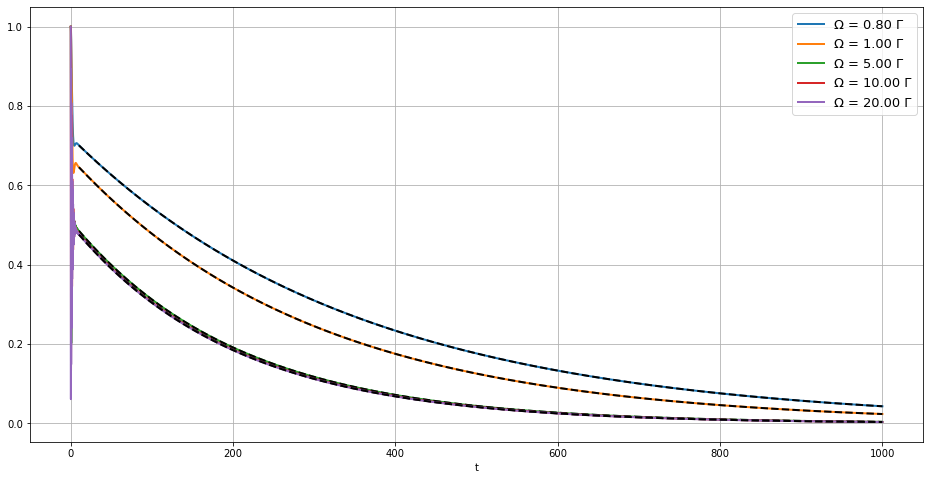

In [2156]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

id_state = 0

tspan = (0,1000)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.8,1,5,10,20]:
    replacements = [(δ, 0), (ga, 0.99), (gb, 0.01), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[id_state,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 10
    xf, yf = x[m], y[id_state,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 0.10 Γ -> λ = 10196.91
Ω = 0.20 Γ -> λ = 2697.19
Ω = 0.40 Γ -> λ = 822.72
Ω = 0.60 Γ -> λ = 476.03


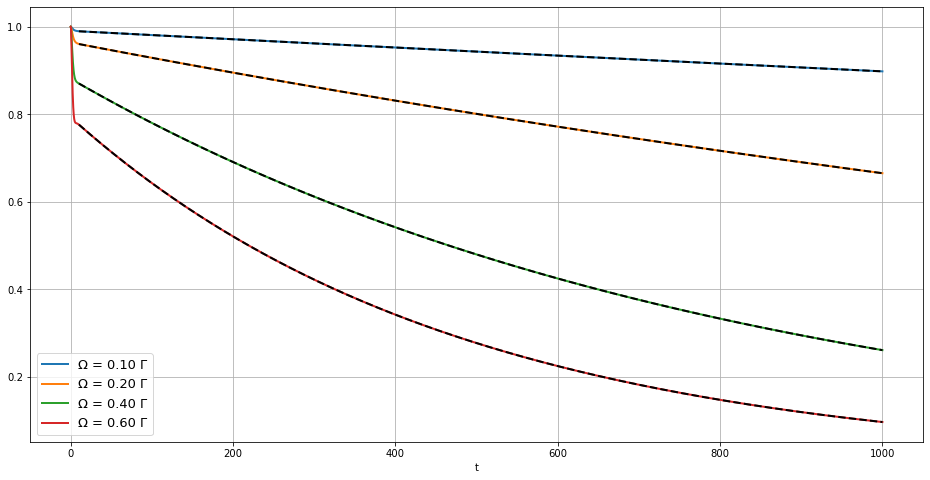

In [2157]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

id_state = 0

tspan = (0,1000)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.1, 0.2, 0.4, 0.6]:
    replacements = [(δ, 0), (ga, 0.99), (gb, 0.01), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[id_state,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 10
    xf, yf = x[m], y[id_state,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

In [2158]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

id_state = 0

tspan = (0,1000)

def run_func(Ωi):
    replacements = [(δ, 0), (ga, 0.99), (gb, 0.01), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
        
    m = x > 10
    xf, yf = x[m], y[id_state,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    return (Ωi, *popt)
    

popt_list = Parallel(n_jobs=6, verbose = 1)(delayed(run_func)(Ωi) 
    for Ωi in np.linspace(0.1, 10, 201)
)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   13.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   51.9s
[Parallel(n_jobs=6)]: Done 201 out of 201 | elapsed:   55.1s finished


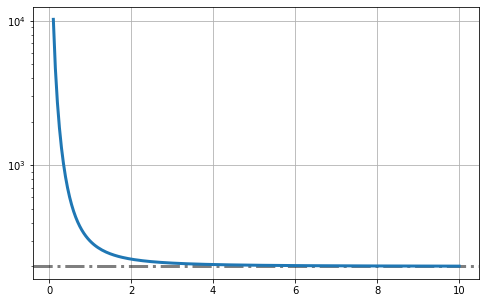

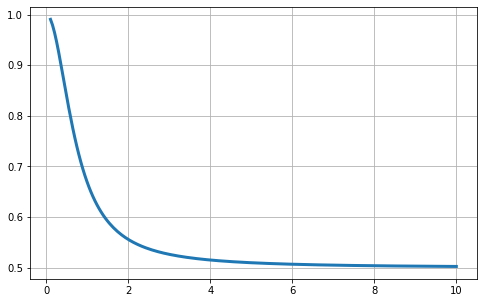

In [2159]:
x,a,λ = np.array(list(zip(*popt_list)))

fig, ax = plt.subplots(figsize = (8,5))
ax.axhline(2/0.01, ls = '-.', color = 'k', lw = 3, alpha = 0.5)
ax.plot(x, λ, lw = 3)
ax.set_yscale('log')
ax.grid(True)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, a, lw = 3)
ax.grid(True)

In [2160]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

id_state = 0

tspan = (0,500)

def run_func(Ωi):
    replacements = [(δ, 0), (ga, 0.7), (gb, 0.3), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
        
    m = x > 10
    xf, yf = x[m], y[id_state,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    return (Ωi, *popt)
    

popt_list = Parallel(n_jobs=6, verbose = 1)(delayed(run_func)(Ωi) 
    for Ωi in np.linspace(0.1, 10, 201)
)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.9s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   26.9s
[Parallel(n_jobs=6)]: Done 201 out of 201 | elapsed:   28.2s finished


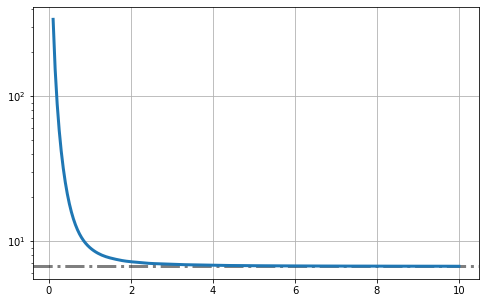

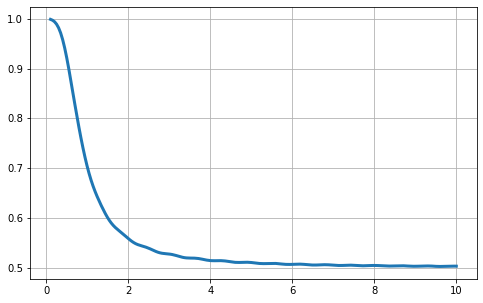

In [2161]:
x,a,λ = np.array(list(zip(*popt_list)))

fig, ax = plt.subplots(figsize = (8,5))
ax.axhline(2/0.3, ls = '-.', color = 'k', lw = 3, alpha = 0.5)
ax.plot(x, λ, lw = 3)
ax.set_yscale('log')
ax.grid(True)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, a, lw = 3)
ax.grid(True)

Ω = 0.80 Γ -> λ = 2.27
Ω = 1.00 Γ -> λ = 3.58
Ω = 5.00 Γ -> λ = 1.77
Ω = 10.00 Γ -> λ = 1.99
Ω = 20.00 Γ -> λ = 2.17


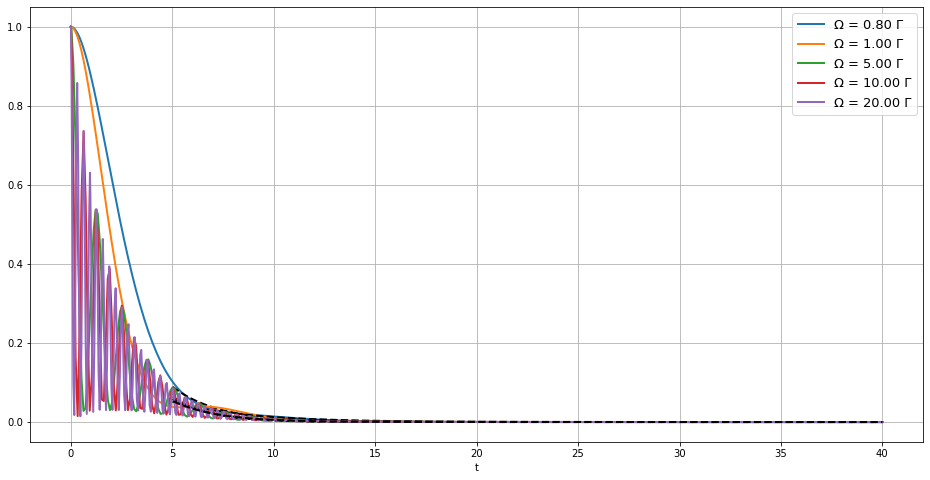

In [2162]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

id_state = 0

tspan = (0,40)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.8,1,5,10,20]:
    replacements = [(δ, 0), (ga, 0.1), (gb, 0.9), (B,10), (WA, Ωi)]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(3,3,-1)).real
    ax.plot(x, y[id_state,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 5
    xf, yf = x[m], y[id_state,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [1, 20])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

In [2165]:
dis_nc = DissipatorNoConjugate(ham.levels)
dis_nc.addDecay(2,0,ga)
dis_nc.addDecay(2,1,1-ga)

bloch_nc = BlochEquations(ham.levels, dis_nc.density_matrix, ham.transformed, dis_nc.dissipator)

In [2166]:
bloch_nc.hamiltonian

Matrix([
[-1.0*δ, 0, -Ω_a/2],
[     0, B,      0],
[-Ω_a/2, 0,      0]])

In [2167]:
from itertools import product
from sympy.solvers.ode.systems import dsolve_system

eqns = [
    Eq(bloch_nc.equations.lhs[idx,idy], bloch_nc.equations.rhs[idx,idy]) 
    for idx,idy in product(range(ham.levels),range(ham.levels))
]
funcs = [
    bloch_nc.density_matrix[idx,idy] for idx,idy in product(range(ham.levels),range(ham.levels))
]
ics = {
    type(bloch_nc.density_matrix[idx,idy])(0): 0 for idx,idy in product(range(ham.levels),range(ham.levels))
}
ics[type(bloch_nc.density_matrix[0,0])(0)] = 1.0 

In [2168]:
eqns = [eq.subs(δ,0) for eq in eqns]
eqns

[Eq(Derivative(ρ₀₀(t), t), Γ_a*ρ₂₂(t) + 0.5*I*Ω_a*(-ρ₀₂(t) + ρ₂₀(t))),
 Eq(Derivative(ρ₀₁(t), t), I*(1.0*B*ρ₀₁(t) + 0.5*Ω_a*ρ₂₁(t))),
 Eq(Derivative(ρ₀₂(t), t), I*(-Ω_a*ρ₀₀(t) + Ω_a*ρ₂₂(t))/2 - ρ₀₂(t)/2),
 Eq(Derivative(ρ₁₀(t), t), I*(-1.0*B*ρ₁₀(t) - 0.5*Ω_a*ρ₁₂(t))),
 Eq(Derivative(ρ₁₁(t), t), (1 - Γ_a)*ρ₂₂(t)),
 Eq(Derivative(ρ₁₂(t), t), I*(-2.0*B*ρ₁₂(t) - 1.0*Ω_a*ρ₁₀(t))/2 - ρ₁₂(t)/2),
 Eq(Derivative(ρ₂₀(t), t), I*(1.0*Ω_a*ρ₀₀(t) - 1.0*Ω_a*ρ₂₂(t))/2 - ρ₂₀(t)/2),
 Eq(Derivative(ρ₂₁(t), t), I*(2*B*ρ₂₁(t) + Ω_a*ρ₀₁(t))/2 - ρ₂₁(t)/2),
 Eq(Derivative(ρ₂₂(t), t), 0.5*I*Ω_a*(ρ₀₂(t) - ρ₂₀(t)) - ρ₂₂(t))]

In [2170]:
# sol = dsolve_system(eqns, funcs = funcs, ics = ics)

# 4 level system with dual drive and decay to 3 states

In [1203]:
A = Symbol(u'A', real = True)
B = Symbol(u'B', real = True)
C = Symbol(u'C', real = True)
E = Symbol(u'E', real = True)

δ = Symbol(u'δ', real = True)
dE = Symbol(u'Δ', real = True)

ga = Symbol(u'Γ_a', real = True)
gb = Symbol(u'Γ_b', real = True)
gc = Symbol(u'Γ_c', real = True)

wA = Symbol(u'ω_a', real = True)
WA = Symbol(u'Ω_a', real = True)
wB = Symbol(u'ω_b', real = True)
WB = Symbol(u'Ω_b', real = True)
ham = Hamiltonian(4)

ham.addEnergies([A, B, C, E])
ham.addCoupling(0,3,WA,wA)
ham.addCoupling(1,3,WB,wB)

ham.eqnTransform()
ham.defineZero(E)
ham.transformed = sympy.Matrix(ham.transformed)
ham.transformed[0,0] = -dE/2 - δ
ham.transformed[1,1] = +dE/2 - δ

dis = Dissipator(ham.levels)
dis.addDecay(3,0,ga)
dis.addDecay(3,1,gb)
dis.addDecay(3,2,gc)

bloch = BlochEquations(dis.levels, dis.density_matrix, ham.transformed, dis.dissipator)

In [1204]:
ham.transformed

Matrix([
[-Δ/2 - δ,       0, 0, -Ω_a/2],
[       0, Δ/2 - δ, 0, -Ω_b/2],
[       0,       0, C,      0],
[  -Ω_a/2,  -Ω_b/2, 0,      0]])

In [1205]:
dis.density_matrix

Matrix([
[           ρ₀₀(t),            ρ₀₁(t),            ρ₀₂(t), ρ₀₃(t)],
[conjugate(ρ₀₁(t)),            ρ₁₁(t),            ρ₁₂(t), ρ₁₃(t)],
[conjugate(ρ₀₂(t)), conjugate(ρ₁₂(t)),            ρ₂₂(t), ρ₂₃(t)],
[conjugate(ρ₀₃(t)), conjugate(ρ₁₃(t)), conjugate(ρ₂₃(t)), ρ₃₃(t)]])

In [1206]:
bloch.hamiltonian

Matrix([
[-Δ/2 - δ,       0, 0, -Ω_a/2],
[       0, Δ/2 - δ, 0, -Ω_b/2],
[       0,       0, C,      0],
[  -Ω_a/2,  -Ω_b/2, 0,      0]])

In [1207]:
bloch.dissipator

Matrix([
[                            Γ_a*ρ₃₃(t),                                      0,                                      0, (-Γ_a - Γ_b - Γ_c)*ρ₀₃(t)/2],
[                                     0,                             Γ_b*ρ₃₃(t),                                      0, (-Γ_a - Γ_b - Γ_c)*ρ₁₃(t)/2],
[                                     0,                                      0,                             Γ_c*ρ₃₃(t), (-Γ_a - Γ_b - Γ_c)*ρ₂₃(t)/2],
[(-Γ_a - Γ_b - Γ_c)*conjugate(ρ₀₃(t))/2, (-Γ_a - Γ_b - Γ_c)*conjugate(ρ₁₃(t))/2, (-Γ_a - Γ_b - Γ_c)*conjugate(ρ₂₃(t))/2,   (-Γ_a - Γ_b - Γ_c)*ρ₃₃(t)]])

Ω = 0.10 Γ -> λ = 10120.37
Ω = 0.20 Γ -> λ = 2935.29
Ω = 0.40 Γ -> λ = 1966.45
Ω = 0.60 Γ -> λ = 3172.25
Ω = 0.80 Γ -> λ = 5227.17
Ω = 1.00 Γ -> λ = 7969.01
Ω = 2.00 Γ -> λ = 31209.36


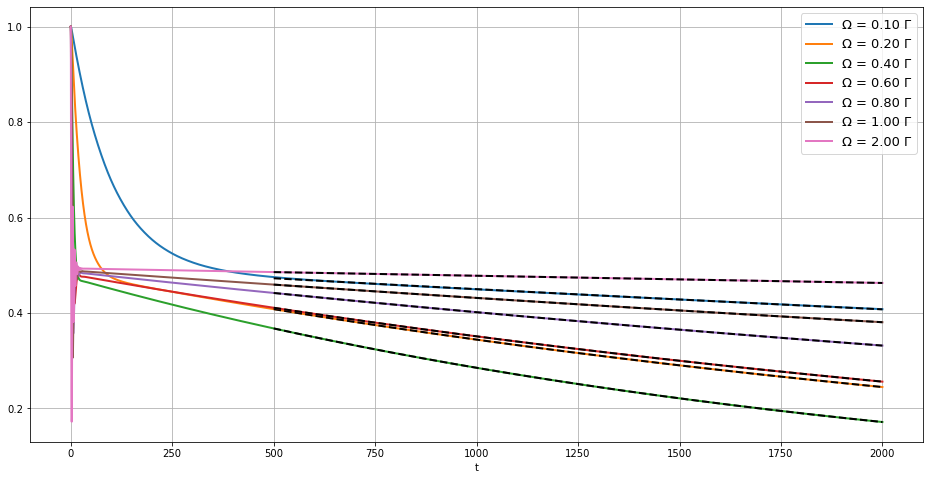

In [1229]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,2000)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0]:
    replacements = [
        (δ, 0), (dE, 0.114), (C,10),
        (ga, 0.5-0.005), (gb, 0.5-0.005), (gc, 0.01),
        (WA, Ωi), (WB, Ωi)
    ]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 500
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [0.5, 200])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
# ax.set_yscale('log')


ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 0.10 Γ -> λ = 2322.72
Ω = 0.20 Γ -> λ = 12902.13
Ω = 0.40 Γ -> λ = 4027.46
Ω = 0.60 Γ -> λ = 2944.58
Ω = 0.80 Γ -> λ = 3428.99
Ω = 1.00 Γ -> λ = 4599.44
Ω = 2.00 Γ -> λ = 16496.34


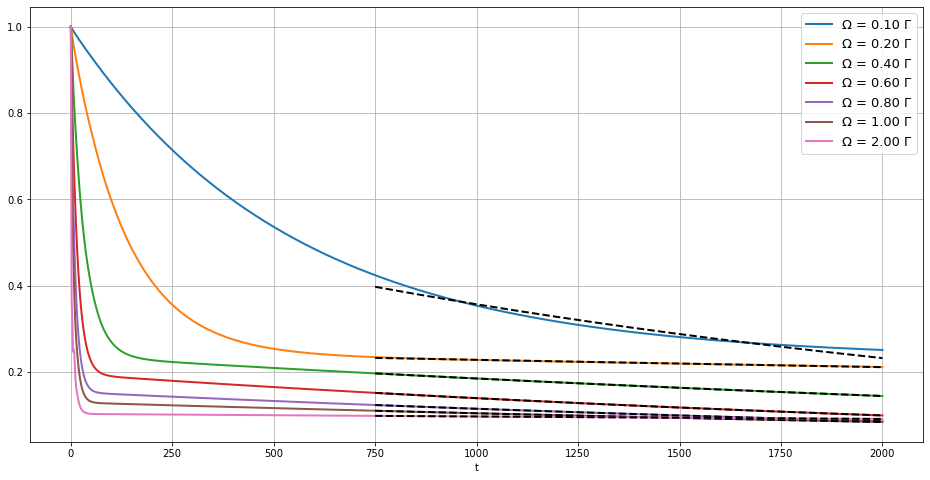

In [1271]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,2000)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0]:
    replacements = [
        (δ, 0), (dE, 0.114), (C,10),
        (ga, 0.75*0.99), (gb, 0.25*0.99), (gc, 0.01),
        (WA, 0.75*Ωi), (WB, 0.25*Ωi)
    ]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 750
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [0.5, 200])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
# ax.set_yscale('log')


ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 0.10 Γ -> λ = 327.03
Ω = 0.20 Γ -> λ = 92.71
Ω = 0.40 Γ -> λ = 67.82
Ω = 0.60 Γ -> λ = 126.92
Ω = 0.80 Γ -> λ = 218.17
Ω = 1.00 Γ -> λ = 337.29
Ω = 2.00 Γ -> λ = 1336.40


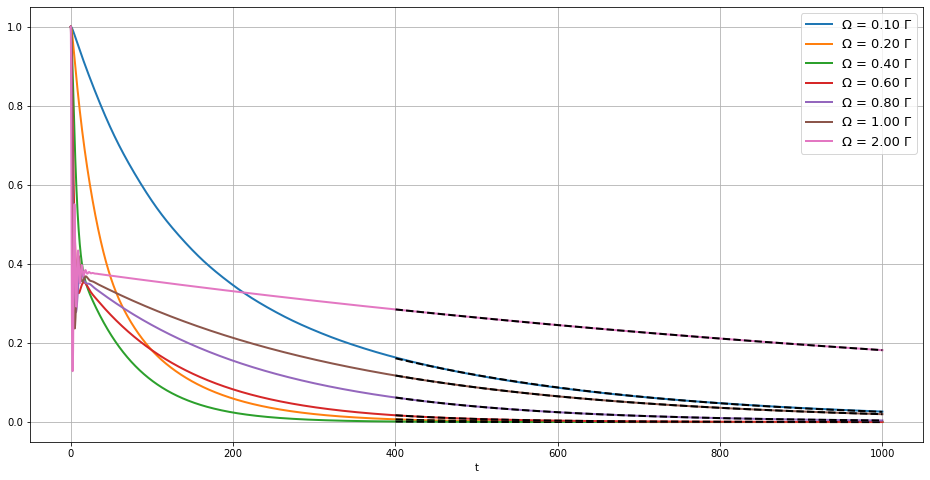

In [1232]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,1000)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0]:
    replacements = [
        (δ, 0), (dE, 0.114), (C,10),
        (ga, 0.35), (gb, 0.35), (gc, 0.3),
        (WA, Ωi), (WB, Ωi)
    ]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 400
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [0.5, 200])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
# ax.set_yscale('log')


ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 0.10 Γ -> λ = 191.12
Ω = 0.20 Γ -> λ = 53.26
Ω = 0.40 Γ -> λ = 41.74
Ω = 0.60 Γ -> λ = 85.49
Ω = 0.80 Γ -> λ = 149.62
Ω = 1.00 Γ -> λ = 232.52
Ω = 2.00 Γ -> λ = 924.78


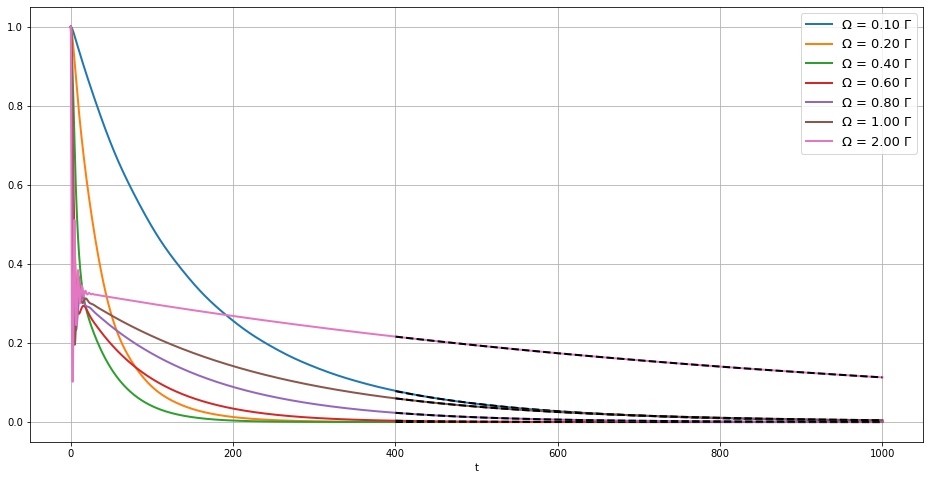

In [1243]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,1000)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0]:
    replacements = [
        (δ, 0), (dE, 0.114), (C,10),
        (ga, 0.25), (gb, 0.25), (gc, 0.5),
        (WA, Ωi), (WB, Ωi)
    ]
    sol = bloch.solveNumeric(replacements, tspan, y0)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 400
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [0.5, 200])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
# ax.set_yscale('log')


ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

Ω = 0.10 Γ -> λ = 180.77
Ω = 0.20 Γ -> λ = 52.52
Ω = 0.40 Γ -> λ = 17.56
Ω = 0.60 Γ -> λ = 23.56
Ω = 0.80 Γ -> λ = 38.91
Ω = 1.00 Γ -> λ = 59.42
Ω = 2.00 Γ -> λ = 232.26


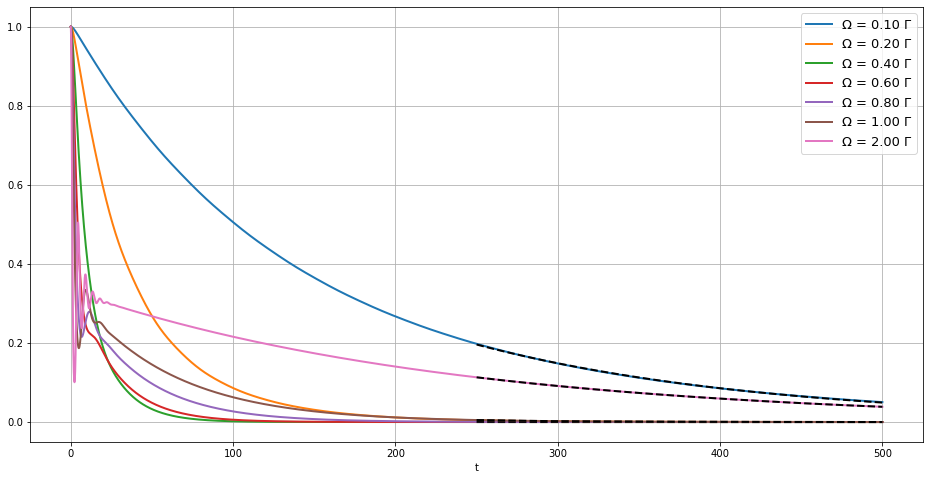

In [1265]:
y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1
y0 = y0.flatten()

tspan = (0,500)

fig, ax = plt.subplots(figsize = (16,8))

for Ωi in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0]:
    replacements = [
        (δ, 0), (dE, 2*0.114), (C,10),
        (ga, 0.25), (gb, 0.25), (gc, 0.5),
        (WA, Ωi), (WB, Ωi)
    ]
    sol = bloch.solveNumeric(replacements, tspan, y0, max_step = 1e-2)
    x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
    ax.plot(x, y[0,:], lw = 2, label = f'Ω = {Ωi:.2f} Γ')
        
    m = x > 250
    xf, yf = x[m], y[0,m]
    popt, pcov = curve_fit(exp_decay, xf, yf, p0 = [0.5, 200])
    
    ax.plot(xf, exp_decay(xf, *popt), '--k', lw = 2)
    print(f"Ω = {Ωi:.2f} Γ -> λ = {popt[1]:.2f}")
    
# ax.set_yscale('log')


ax.set_xlabel('t')
ax.legend(fontsize = 13)
ax.grid(True)

# 4 level system in Dark/Bright basis, only decay to non-interacting level

In [2047]:
A = Symbol(u'A', real = True)
B = Symbol(u'B', real = True)
C = Symbol(u'C', real = True)
E = Symbol(u'E', real = True)

δ = Symbol(u'δ', real = True)
dE = Symbol(u'Δ', real = True)

gc = Symbol(u'Γ_c', real = True)

wA = Symbol(u'ω_a', real = True)
WA = Symbol(u'Ω_a', real = True)
wB = Symbol(u'ω_b', real = True)
WB = Symbol(u'Ω_b', real = True)
ham = Hamiltonian(4)

ham.addEnergies([A, B, C, E])
ham.addCoupling(0,3,WA,wA)
ham.addCoupling(1,3,WB,wB)

ham.eqnTransform()
ham.defineZero(E)
ham.transformed = sympy.Matrix(ham.transformed)
ham.transformed[0,0] = -dE/2 - δ
ham.transformed[1,1] = +dE/2 - δ

dis = Dissipator(ham.levels)
dis.addDecay(3,2,gc)

bloch = BlochEquations(dis.levels, dis.density_matrix, ham.transformed, dis.dissipator)

In [2048]:
a,b,Ω = symbols("a b Ω")
new_basis = sympy.Matrix([
    [-b/sympy.sqrt(a**2+b**2), a/sympy.sqrt(a**2+b**2), 0, 0],
    [a/sympy.sqrt(a**2+b**2), b/sympy.sqrt(a**2+b**2), 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

In [2049]:
bloch.hamiltonian = bloch.hamiltonian.subs([(WA, a*Ω),(WB, b*Ω)])
bloch.hamiltonian = sympy.simplify(new_basis.T@bloch.hamiltonian@new_basis)
bloch.hamiltonian

Matrix([
[(a**2*(Δ - 2*δ) - b**2*(Δ + 2*δ))/(2*(a**2 + b**2)),                                  a*b*Δ/(a**2 + b**2), 0,                      0],
[                                a*b*Δ/(a**2 + b**2), (-a**2*(Δ + 2*δ) + b**2*(Δ - 2*δ))/(2*(a**2 + b**2)), 0, -Ω*sqrt(a**2 + b**2)/2],
[                                                  0,                                                    0, C,                      0],
[                                                  0,                               -Ω*sqrt(a**2 + b**2)/2, 0,                      0]])

In [2050]:
bloch.generateEquations()
bloch.generateEquationsSteadyState()

## No light, dark/bright oscillations

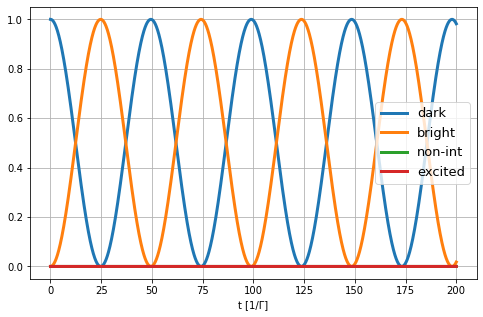

In [2051]:
# a and b for Q(1) F1'=1/2 F'=0 z pol system
a_value = 1
b_value = 0.58158
# Δ for Q(1) F1'=1/2 F'=0 z pol system
Δi = 0.113

T = new_basis.subs([(a,a_value), (b, 1-a_value)])

y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1.0

# y0 = T.T@y0@T

y0 = y0.flatten()

tspan = (0,200)

fig, ax = plt.subplots(figsize = (8,5))

replacements = [
    (δ, 0), 
    (dE, 0.127), 
    (C,1),
    (gc, 1),
    (a, a_value),
    (b, a_value),
    (Ω, 0)
]
sol = bloch.solveNumeric(replacements, tspan, y0)
x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
ax.plot(x, y.T, lw = 3, label = ['dark', 'bright', 'non-int', 'excited'])    


ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

### Solve analytically for no light

In [2052]:
from itertools import product
from sympy.utilities.iterables import flatten
from sympy.solvers.ode.systems import dsolve_system

ρ = generate_density_matrix(2)

eqns = sympy.simplify(sympy.Eq(sympy.diff(ρ), -sympy.I*commute(bloch.hamiltonian[:2,:2], ρ)))
eqns = [sympy.Eq(eqns.lhs[idx,idy], eqns.rhs[idx,idy]) for idx,idy in product(range(2),range(2))]
                
funcs = flatten(ρ)
ics = {
    type(d)(0): 0 for d in flatten(ρ)
}
ics[type(ρ[0,0])(0)] = 1

In [2053]:
eqns

[Eq(Derivative(ρ₀₀(t), t), I*a*b*Δ*(ρ₀₁(t) - ρ₁₀(t))/(a**2 + b**2)),
 Eq(Derivative(ρ₀₁(t), t), I*Δ*(-a**2*ρ₀₁(t) + a*b*ρ₀₀(t) - a*b*ρ₁₁(t) + b**2*ρ₀₁(t))/(a**2 + b**2)),
 Eq(Derivative(ρ₁₀(t), t), I*Δ*(a**2*ρ₁₀(t) - a*b*ρ₀₀(t) + a*b*ρ₁₁(t) - b**2*ρ₁₀(t))/(a**2 + b**2)),
 Eq(Derivative(ρ₁₁(t), t), I*a*b*Δ*(-ρ₀₁(t) + ρ₁₀(t))/(a**2 + b**2))]

In [2054]:
sol = dsolve_system(eqns, funcs = funcs, ics = ics)

display(sympy.simplify(sol[0][0].rewrite(sympy.cos)))
display(sympy.simplify(sol[0][3].rewrite(sympy.cos)))

Eq(ρ₀₀(t), (a**4 + 2*a**2*b**2*cos(t*Δ) + b**4)/(a**4 + 2*a**2*b**2 + b**4))

Eq(ρ₁₁(t), 2*a**2*b**2*(1 - cos(t*Δ))/(a**4 + 2*a**2*b**2 + b**4))

In [2055]:
pop_dark = sympy.lambdify([t,a,b,dE],sympy.simplify(sol[0][0].rewrite(sympy.cos)).rhs)

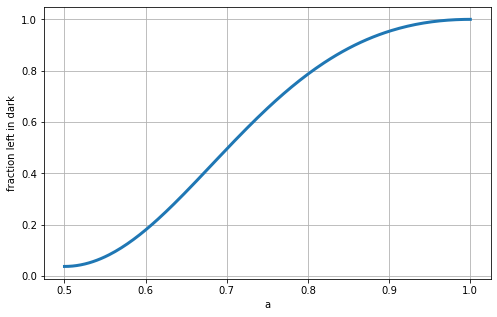

In [2057]:
a_scan = np.linspace(0.5,1,201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(
    a_scan, pop_dark(np.pi/Δi, a_scan, 1-a_scan, 0.127), 
    lw = 3
)
ax.set_xlabel("a")
ax.set_ylabel("fraction left in dark")

ax.grid(True)

## Pulsing the laser

### single pulse

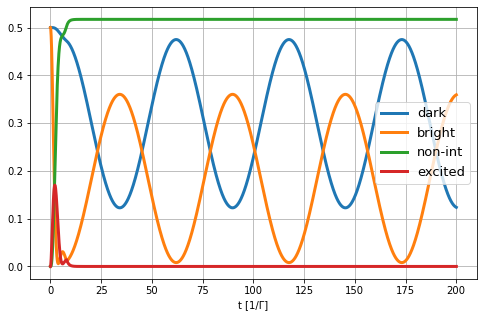

In [2062]:
# a and b for Q(1) F1'=1/2 F'=0 z pol system
a_value = 1
b_value = 0.58158
# Δ for Q(1) F1'=1/2 F'=0 z pol system
Δi = 0.113
dτ = 8

T = sympy.matrix2numpy(
    new_basis.subs([(a,a_value), (b, 1-a_value)]), 
    dtype = float
)

y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1/2
y0[1,1] = 1/2

y0 = T.T@y0@T

y0 = y0.flatten()

tspan = (0,200)

tswitch = []
idτ = 0
idΔ = 0
for idx in range(2):
    if idx%2 == 0:
        idτ += 1
    elif idx%2 == 1:
        idΔ += 1
    tswitch.append(
        (1 if idx%2 == 0 else 0, t < idτ * dτ + idΔ * (np.pi/Δi-dτ) )
    )
tswitch.append((0,True))
tswitch = sympy.Piecewise(*tswitch)   

fig, ax = plt.subplots(figsize = (8,5))

replacements = [
    (δ, 0), 
    (dE, Δi), 
    (C,1),
    (gc, 1),
    (a, a_value),
    (b, b_value),
    (Ω, tswitch)
]
sol = bloch.solveNumeric(replacements, tspan, y0)
x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
ax.plot(x, y.T, lw = 3, label = ['dark', 'bright', 'non-int', 'excited'])    


ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

In [2063]:
print(f"fraction left if bright is immediately empty: {pop_dark(np.pi/Δi, a_value, b_value, Δi)/2:.3f}")
print(f"fraction left after one laser pulse (sim): {y[0].min():.3f}")

fraction left if bright is immediately empty: 0.122
fraction left after one laser pulse (sim): 0.123


### multiple pulses

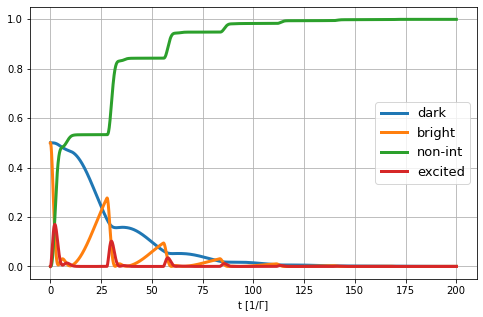

In [2064]:
# a and b for Q(1) F1'=1/2 F'=0 z pol system
a_value = 1
b_value = 0.58158
# Δ for Q(1) F1'=1/2 F'=0 z pol system
Δi = 0.113
dτ = 10

T = sympy.matrix2numpy(
    new_basis.subs([(a,a_value), (b, 1-a_value)]), 
    dtype = float
)

y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1/2
y0[1,1] = 1/2

y0 = T.T@y0@T

y0 = y0.flatten()

tspan = (0,200)

tswitch = []
idτ = 0
idΔ = 0
for idx in range(14):
    if idx%2 == 0:
        idτ += 1
    elif idx%2 == 1:
        idΔ += 1
    tswitch.append(
        (1 if idx%2 == 0 else 0, t < idτ * dτ + idΔ * (np.pi/Δi-dτ) )
    )
tswitch.append((0,True))
tswitch = sympy.Piecewise(*tswitch)   

fig, ax = plt.subplots(figsize = (8,5))

replacements = [
    (δ, 0), 
    (dE, Δi), 
    (C,1),
    (gc, 1),
    (a, a_value),
    (b, b_value),
    (Ω, tswitch)
]
sol = bloch.solveNumeric(replacements, tspan, y0)
x, y = sol.t, np.einsum('iij -> ij', sol.y.reshape(ham.levels,ham.levels,-1)).real
ax.plot(x, y.T, lw = 3, label = ['dark', 'bright', 'non-int', 'excited'])

ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

In [2068]:
n_pulses = np.log(1e-2) / np.log(pop_dark(np.pi/Δi, a_value, b_value, Δi))
print(f"{n_pulses:.2f} pulses to get below 1%")
print(f"{np.ceil(n_pulses)*np.pi/Δi:.2f} 1/Γ time required")
print(f"for TlF that would be {np.ceil(n_pulses)*np.pi/Δi * 100e-9 * 1e6:.2f} μs")

3.27 pulses to get below 1%
111.21 1/Γ time required
for TlF that would be 11.12 μs


# 4 level system in Dark/Bright basis, decay to all levels

In [2073]:
A = Symbol(u'A', real = True)
B = Symbol(u'B', real = True)
C = Symbol(u'C', real = True)
E = Symbol(u'E', real = True)

δ = Symbol(u'δ', real = True)
dE = Symbol(u'Δ', real = True)

ga = Symbol(u'Γ_a', real = True)
gb = Symbol(u'Γ_b', real = True)
gc = Symbol(u'Γ_c', real = True)

wA = Symbol(u'ω_a', real = True)
WA = Symbol(u'Ω_a', real = True)
wB = Symbol(u'ω_b', real = True)
WB = Symbol(u'Ω_b', real = True)
ham = Hamiltonian(4)

ham.addEnergies([A, B, C, E])
ham.addCoupling(0,3,WA,wA)
ham.addCoupling(1,3,WB,wB)

ham.eqnTransform()
ham.defineZero(E)
ham.transformed = sympy.Matrix(ham.transformed)
ham.transformed[0,0] = -dE/2 - δ
ham.transformed[1,1] = +dE/2 - δ

dis = Dissipator(ham.levels)
dis.addDecay(3,0,ga)
dis.addDecay(3,1,gb)
dis.addDecay(3,2,gc)

bloch = BlochEquations(dis.levels, dis.density_matrix, ham.transformed, dis.dissipator)

In [2074]:
a,b,Ω = symbols("a b Ω")
new_basis = sympy.Matrix([
    [-b/sympy.sqrt(a**2+b**2), a/sympy.sqrt(a**2+b**2), 0, 0],
    [a/sympy.sqrt(a**2+b**2), b/sympy.sqrt(a**2+b**2), 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

In [2075]:
bloch.hamiltonian = bloch.hamiltonian.subs([(WA, a*Ω),(WB, b*Ω)])
bloch.generateEquations()
bloch.hamiltonian

Matrix([
[-Δ/2 - δ,       0, 0, -a*Ω/2],
[       0, Δ/2 - δ, 0, -b*Ω/2],
[       0,       0, C,      0],
[  -a*Ω/2,  -b*Ω/2, 0,      0]])

## No light, dark/bright oscillations

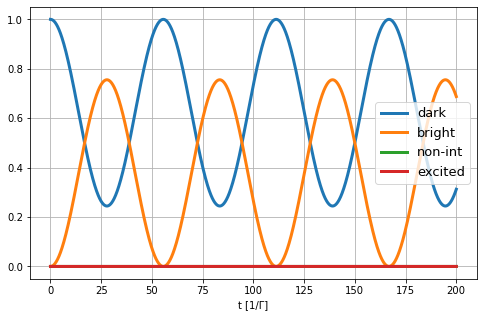

In [2079]:
# a and b for Q(1) F1'=1/2 F'=0 z pol system
a_value = 1
b_value = 0.58158
# Δ for Q(1) F1'=1/2 F'=0 z pol system
Δi = 0.113

T = sympy.matrix2numpy(new_basis.subs([(a,a_value), (b, b_value)]), dtype = float)

y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1.0

y0 = T.T@y0@T

y0 = y0.flatten()

tspan = (0,200)

fig, ax = plt.subplots(figsize = (8,5))

replacements = [
    (δ, 0), 
    (dE, Δi), (C,1),
    (ga, 0.25), (gb, 0.08), (gc, 1-0.25-0.08),
    (a, a_value),
    (b, b_value),
    (Ω, 0)
]

sol = bloch.solveNumeric(replacements, tspan, y0)

y = sol.y.reshape(ham.levels,ham.levels,-1)
y = T.T@y.T@T
x, y = sol.t, np.einsum('jii -> ij', y).real

ax.plot(x, y.T, lw = 3, label = ['dark', 'bright', 'non-int', 'excited'])    

ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

## Pulsing the laser

### single pulse

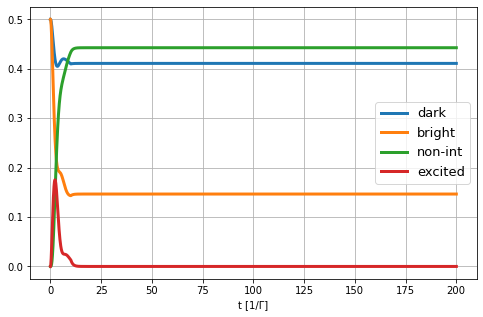

In [2080]:
# a and b for Q(1) F1'=1/2 F'=0 z pol system
a_value = 1
b_value = 0.58158
# Δ for Q(1) F1'=1/2 F'=0 z pol system
Δi = 0.113
dτ = 10

T = sympy.matrix2numpy(
    new_basis.subs([(a,a_value), (b, 1-a_value)]), 
    dtype = float
)

y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1/2
y0[1,1] = 1/2

y0 = T.T@y0@T

y0 = y0.flatten()

tspan = (0,200)

tswitch = []
idτ = 0
idΔ = 0
for idx in range(2):
    if idx%2 == 0:
        idτ += 1
    elif idx%2 == 1:
        idΔ += 1
    tswitch.append(
        (1 if idx%2 == 0 else 0, t < idτ * dτ + idΔ * (np.pi/Δi-dτ) )
    )
tswitch.append((0,True))
tswitch = sympy.Piecewise(*tswitch)   

fig, ax = plt.subplots(figsize = (8,5))

replacements = [
    (δ, 0), 
    (dE, Δi), (C,1),
    (ga, 0.25), (gb, 0.08), (gc, 1-0.25-0.08),
    (a, a_value),
    (b, b_value),
    (Ω, tswitch)
]

sol = bloch.solveNumeric(replacements, tspan, y0)

y = sol.y.reshape(ham.levels,ham.levels,-1)
y = T.T@y.T@T
x, y = sol.t, np.einsum('jii -> ij', y).real

ax.plot(x, y.T, lw = 3, label = ['dark', 'bright', 'non-int', 'excited'])    


ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

In [1647]:
print(f"fraction left if bright is immediately empty: {pop_dark(np.pi/Δi, a_value, 1-a_value, Δi)/2:.3f}")
print(f"dark minimum left after one laser pulse (sim): {y[0].min():.3f}")
print(f"dark maximum left after one laser pulse (sim): {y[0].max():.3f}")

fraction left if bright is immediately empty: 0.133
dark minimum left after one laser pulse (sim): 0.001
dark maximum left after one laser pulse (sim): 0.536


Now 8% decays back to the dark state and 25% back to the bright state.  
Assuming the bright state starts with 0.5 population and is completely emptied out in the pulse, $\approx 0.04$ ($0.08\cdot0.05$) decays back to the dark state.

### multiple pulses

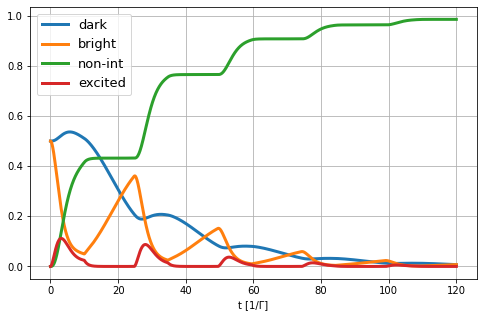

In [2025]:
a_value = 0.639
Δi = 0.127
dτ = 10

T = sympy.matrix2numpy(
    new_basis.subs([(a,a_value), (b, 1-a_value)]), 
    dtype = float
)

y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1/2
y0[1,1] = 1/2

y0 = T.T@y0@T

y0 = y0.flatten()

tspan = (0,120)

tswitch = []
idτ = 0
idΔ = 0
for idx in range(14):
    if idx%2 == 0:
        idτ += 1
    elif idx%2 == 1:
        idΔ += 1
    tswitch.append(
        (1 if idx%2 == 0 else 0, t < idτ * dτ + idΔ * (np.pi/Δi-dτ) )
    )
tswitch.append((0,True))
tswitch = sympy.Piecewise(*tswitch)   

fig, ax = plt.subplots(figsize = (8,5))

replacements = [
    (δ, 0), 
    (dE, Δi), (C,1),
    (ga, 0.25), (gb, 0.08), (gc, 1-0.25-0.08),
    (a, a_value),
    (b, 1-a_value),
    (Ω, tswitch)
]

sol = bloch.solveNumeric(replacements, tspan, y0)

y = sol.y.reshape(ham.levels,ham.levels,-1)
y = T.T@y.T@T
x, y = sol.t, np.einsum('jii -> ij', y).real

ax.plot(x, y.T, lw = 3, label = ['dark', 'bright', 'non-int', 'excited'])

ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

In [2026]:
print(f"after 5 pulses removed {y[2].max():.3f} population ")
print(f"population in bright after the first pulse + evolution {y[1][100:400].max():.3f}")
print(f"population removed after first pulse + evolution {y[2][:200].max():.3f}")

after 5 pulses removed 0.985 population 
population in bright after the first pulse + evolution 0.361
population removed after first pulse + evolution 0.432


### Simple Markov Chain Model

In [1755]:
pulse = np.array([
    [1, 0.08, 0],
    [0, 0, 0],
    [0, 0.92, 1]
])
dark_after_evo = pop_dark(np.pi/Δi, a_value, 1-a_value, Δi)
evolution = np.array([
    [dark_after_evo, 0, 0],
    [1-dark_after_evo, 1, 0],
    [0, 0, 1]
])

pops = np.array([1/2, 1/2, 0])

In [1758]:
# 1 pulse
pulse@np.linalg.matrix_power(evolution@pulse, 1)@pops

array([0.17553379, 0.        , 0.82446621])

### Markov Chain Model with more realistic couplings

In [2023]:
iterations = 2
to_dark = np.sum([0.08*0.25**i for i in range(iterations)])
pulse = np.array([
    [1, to_dark, 0],
    [0, 0.25**iterations, 0],
    [0, 1-to_dark-0.25**iterations, 1]
])

dark_after_evo = pop_dark(np.pi/Δi, a_value, 1-a_value, Δi)
evolution = np.array([
    [dark_after_evo, 0, 0],
    [1-dark_after_evo, 1, 0],
    [0, 0, 1]
])

pops = np.array([1/2, 1/2, 0])

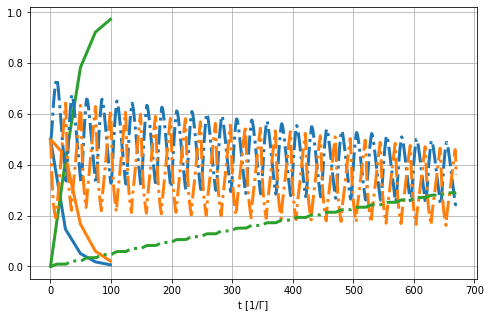

In [2024]:
n_pulses = 5
dat = []
for i in range(n_pulses):
    dat.append(np.linalg.matrix_power(evolution@pulse, i)@pops)
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.arange(n_pulses)*np.pi/Δi, np.array(dat), lw = 3)
for ci, yi in zip(['C0', 'C1', 'C2'], y[:3]):
    ax.plot(x, yi, lw = 3, ls = '-.', color = ci)
ax.set_xlabel("t [1/Γ]")
ax.grid(True)

In [1760]:
# 5 pulses
np.linalg.matrix_power(evolution@pulse,5)@pops

array([0.0020797 , 0.00573185, 0.99218845])

In [1772]:
n_pulses = 5
print(f"{n_pulses} pulses to get below 1%")
print(f"{np.ceil(n_pulses)*np.pi/Δi:.2f} 1/Γ time required")

λ = -np.ceil(n_pulses)*np.pi/Δi / np.log(1-0.99)
print(f"λ = {λ:.0f} 1/Γ")
print(f"for TlF that would mean an approximate lifetime of λ = {1/1.56e6 * λ * 1e6:.0f} μs")

5 pulses to get below 1%
123.68 1/Γ time required
λ = 27 1/Γ
for TlF that would mean an approximate lifetime of λ = 17 μs


### With decays simulating 3 separate polarization states

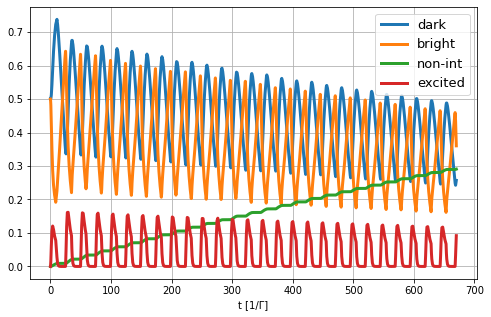

In [1999]:
a_value = 0.639
Δi = 0.127
dτ = 10

T = sympy.matrix2numpy(
    new_basis.subs([(a,a_value), (b, 1-a_value)]), 
    dtype = float
)

y0 = np.zeros((bloch.levels,bloch.levels), dtype = complex)
y0[0,0] = 1/2
y0[1,1] = 1/2

y0 = T.T@y0@T

y0 = y0.flatten()

tspan = (0,670)

tswitch = []
idτ = 0
idΔ = 0
for idx in range(55):
    if idx%2 == 0:
        idτ += 1
    elif idx%2 == 1:
        idΔ += 1
    tswitch.append(
        (1 if idx%2 == 0 else 0, t < idτ * dτ + idΔ * (np.pi/Δi-dτ) )
    )
tswitch.append((0,True))
tswitch = sympy.Piecewise(*tswitch)   

fig, ax = plt.subplots(figsize = (8,5))

replacements = [
    (δ, 0), 
    (dE, Δi), (C,1),
    (ga, 0.25*3), (gb, 0.08*3), (gc, 1-0.25*3-0.08*3),
    (a, a_value),
    (b, 1-a_value),
    (Ω, tswitch)
]

sol = bloch.solveNumeric(replacements, tspan, y0, max_step = 2)

y = sol.y.reshape(ham.levels,ham.levels,-1)
y = T.T@y.T@T
x, y = sol.t, np.einsum('jii -> ij', y).real

ax.plot(x, y.T, lw = 3, label = ['dark', 'bright', 'non-int', 'excited'])

ax.set_xlabel('t [1/Γ]')
ax.legend(fontsize = 13)
ax.grid(True)

In [2020]:
iterations = 3
to_dark = np.sum([(0.24)*(0.75)**i for i in range(iterations)])
to_bright = 0.75**iterations
pulse = np.array([
    [1, to_dark, 0],
    [0, to_bright, 0],
    [0, 1-to_dark-to_bright, 1]
])

dark_after_evo = pop_dark(np.pi/Δi, a_value, 1-a_value, Δi)
evolution = np.array([
    [dark_after_evo, 0, 0],
    [1-dark_after_evo, 1, 0],
    [0, 0, 1]
])

pops = np.array([1/2, 1/2, 0])

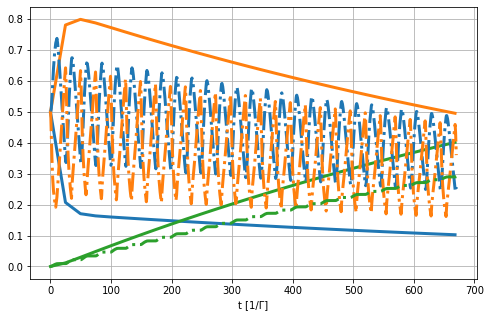

In [2021]:
n_pulses = 28
dat = []
for i in range(n_pulses):
    dat.append(np.linalg.matrix_power(evolution@pulse, i)@pops)
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.arange(n_pulses)*np.pi/Δi, np.array(dat), lw = 3)
for ci, yi in zip(['C0', 'C1', 'C2'], y[:3]):
    ax.plot(x, yi, lw = 3, ls = '-.', color = ci)
ax.set_xlabel("t [1/Γ]")
ax.grid(True)

### Markov Chain Model for 1 excited state and 6 ground states (mF = -1, 0, +1)

In [1950]:
to_dark = np.sum([0.08*0.25**i for i in range(6)])
to_bright = np.sum([0.25*0.25**i for i in range(6)])
to_vibrational = np.sum([0.01*0.25**i for i in range(6)])
pulse = np.array([
    [1, to_dark, 0, to_dark, 0, to_dark, 0],
    [0, 0.25**6, 0, to_bright, 0, to_bright, 0],
    [0, to_dark, 1, to_dark, 0, to_dark, 0],
    [0, to_bright, 0, 0.25**6, 0, to_bright, 0],
    [0, to_dark, 0, to_dark, 1, to_dark, 0],
    [0, to_bright, 0, to_bright, 0, 0.25**6, 0],
    [0, to_vibrational, 0, to_vibrational, 0, to_vibrational, 1]
])

dark_after_evo = pop_dark(np.pi/Δi, a_value, 1-a_value, Δi)
evolution = np.array([
    [dark_after_evo  , 0, 0, 0, 0, 0, 0],
    [1-dark_after_evo, 1, 0, 0, 0, 0, 0],
    [0, 0, dark_after_evo  , 0, 0, 0, 0],
    [0, 0, 1-dark_after_evo, 1, 0, 0, 0],
    [0, 0, 0, 0, dark_after_evo  , 0, 0],
    [0, 0, 0, 0, 1-dark_after_evo, 1, 0],
    [0, 0, 0, 0, 0, 0, 1]
])

pops = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6, 0])

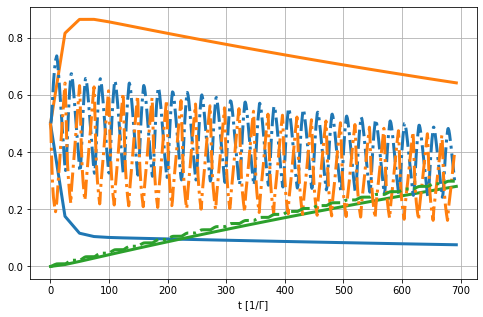

In [1967]:
n_pulses = 29
dat = []
for i in range(n_pulses):
    dat.append(np.linalg.matrix_power(evolution@pulse, i)@pops)

dark = np.sum(np.array(dat).T[:-1:2], axis = 0)
bright = np.sum(np.array(dat).T[1:-1:2], axis = 0)
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.arange(n_pulses)*np.pi/Δi, dark, lw = 3)
ax.plot(np.arange(n_pulses)*np.pi/Δi, bright, lw = 3)
ax.plot(np.arange(n_pulses)*np.pi/Δi, np.array(dat).T[-1], lw = 3)

for ci, yi in zip(['C0', 'C1', 'C2'], y[:3]):
    ax.plot(x, yi, lw = 3, ls = '-.', color = ci)

ax.set_xlabel("t [1/Γ]")
ax.grid(True)

In [1968]:
# 100 pulses
np.linalg.matrix_power(evolution@pulse,200)@pops

array([0.00321821, 0.02725467, 0.00321821, 0.02725467, 0.00321821,
       0.02725467, 0.90858136])

In [1969]:
n_pulses = 100
print(f"{n_pulses} pulses to get below 10%")
print(f"{np.ceil(n_pulses)*np.pi/Δi:.2f} 1/Γ time required")

λ = -np.ceil(n_pulses)*np.pi/Δi / np.log(1-0.9)
print(f"λ = {λ:.0f} 1/Γ")
print(f"for TlF that would mean an approximate lifetime of λ = {1/1.56e6 * λ * 1e6:.0f} μs")

100 pulses to get below 10%
2473.70 1/Γ time required
λ = 1074 1/Γ
for TlF that would mean an approximate lifetime of λ = 689 μs


In [2104]:
dis_nc = DissipatorNoConjugate(ham.levels)
dis_nc.addDecay(3,0,ga)
dis_nc.addDecay(3,1,gb)
dis_nc.addDecay(3,2,gc)
bloch_nc = BlochEquations(ham.levels, dis_nc.density_matrix, ham.transformed, dis_nc.dissipator)
bloch_nc.hamiltonian = bloch_nc.hamiltonian.subs([(WA, a*Ω), (WB, b*Ω), (δ, 0)])
bloch_nc.generateEquations()
bloch_nc.equations = bloch_nc.equations.subs(gc, 1-ga-gb)
bloch_nc.hamiltonian

Matrix([
[  -Δ/2,      0, 0, -a*Ω/2],
[     0,    Δ/2, 0, -b*Ω/2],
[     0,      0, C,      0],
[-a*Ω/2, -b*Ω/2, 0,      0]])

In [2105]:
from itertools import product
from sympy.solvers.ode.systems import dsolve_system

density_matrix = dis_nc.density_matrix

eqns = [
    Eq(bloch_nc.equations.lhs[idx,idy], bloch_nc.equations.rhs[idx,idy]) 
    for idx,idy in product(range(bloch_nc.levels),range(bloch_nc.levels))
]
funcs = [
    density_matrix[idx,idy] for idx,idy in product(range(bloch_nc.levels),range(bloch_nc.levels))
]
ics = {
    type(density_matrix[idx,idy])(0): 0 for idx,idy in product(range(bloch_nc.levels),range(bloch_nc.levels))
}
ics[type(density_matrix[0,0])(0)] = 1/2
ics[type(density_matrix[1,1])(0)] = 1/2

In [2106]:
for i,f in enumerate(funcs):
    print(i, f)

0 ρ₀₀(t)
1 ρ₀₁(t)
2 ρ₀₂(t)
3 ρ₀₃(t)
4 ρ₁₀(t)
5 ρ₁₁(t)
6 ρ₁₂(t)
7 ρ₁₃(t)
8 ρ₂₀(t)
9 ρ₂₁(t)
10 ρ₂₂(t)
11 ρ₂₃(t)
12 ρ₃₀(t)
13 ρ₃₁(t)
14 ρ₃₂(t)
15 ρ₃₃(t)


In [2111]:
bloch_nc.hamiltonian

Matrix([
[  -Δ/2,      0, 0, -a*Ω/2],
[     0,    Δ/2, 0, -b*Ω/2],
[     0,      0, C,      0],
[-a*Ω/2, -b*Ω/2, 0,      0]])

In [2110]:
bloch_nc.equations

Eq(Matrix([
[Derivative(ρ₀₀(t), t), Derivative(ρ₀₁(t), t), Derivative(ρ₀₂(t), t), Derivative(ρ₀₃(t), t)],
[Derivative(ρ₁₀(t), t), Derivative(ρ₁₁(t), t), Derivative(ρ₁₂(t), t), Derivative(ρ₁₃(t), t)],
[Derivative(ρ₂₀(t), t), Derivative(ρ₂₁(t), t), Derivative(ρ₂₂(t), t), Derivative(ρ₂₃(t), t)],
[Derivative(ρ₃₀(t), t), Derivative(ρ₃₁(t), t), Derivative(ρ₃₂(t), t), Derivative(ρ₃₃(t), t)]]), Matrix([
[                       0.5*I*a*Ω*(-ρ₀₃(t) + ρ₃₀(t)) + Γ_a*ρ₃₃(t),               I*(0.5*a*Ω*ρ₃₁(t) - 0.5*b*Ω*ρ₀₃(t) + 1.0*Δ*ρ₀₁(t)),      I*(1.0*C*ρ₀₂(t) + 0.5*a*Ω*ρ₃₂(t) + 0.5*Δ*ρ₀₂(t)), -I*(a*Ω*ρ₀₀(t) - a*Ω*ρ₃₃(t) + b*Ω*ρ₀₁(t) - Δ*ρ₀₃(t))/2 - ρ₀₃(t)/2],
[             I*(-0.5*a*Ω*ρ₁₃(t) + 0.5*b*Ω*ρ₃₀(t) - 1.0*Δ*ρ₁₀(t)),                        0.5*I*b*Ω*(-ρ₁₃(t) + ρ₃₁(t)) + Γ_b*ρ₃₃(t),      I*(1.0*C*ρ₁₂(t) + 0.5*b*Ω*ρ₃₂(t) - 0.5*Δ*ρ₁₂(t)), -I*(a*Ω*ρ₁₀(t) + b*Ω*ρ₁₁(t) - b*Ω*ρ₃₃(t) + Δ*ρ₁₃(t))/2 - ρ₁₃(t)/2],
[               I*(-1.0*C*ρ₂₀(t) - 0.5*a*Ω*ρ₂₃(t) - 0.5*Δ*ρ₂₀(t)),                I*(-1.0

In [2107]:
eqns

[Eq(Derivative(ρ₀₀(t), t), 0.5*I*a*Ω*(-ρ₀₃(t) + ρ₃₀(t)) + Γ_a*ρ₃₃(t)),
 Eq(Derivative(ρ₀₁(t), t), I*(0.5*a*Ω*ρ₃₁(t) - 0.5*b*Ω*ρ₀₃(t) + 1.0*Δ*ρ₀₁(t))),
 Eq(Derivative(ρ₀₂(t), t), I*(1.0*C*ρ₀₂(t) + 0.5*a*Ω*ρ₃₂(t) + 0.5*Δ*ρ₀₂(t))),
 Eq(Derivative(ρ₀₃(t), t), -I*(a*Ω*ρ₀₀(t) - a*Ω*ρ₃₃(t) + b*Ω*ρ₀₁(t) - Δ*ρ₀₃(t))/2 - ρ₀₃(t)/2),
 Eq(Derivative(ρ₁₀(t), t), I*(-0.5*a*Ω*ρ₁₃(t) + 0.5*b*Ω*ρ₃₀(t) - 1.0*Δ*ρ₁₀(t))),
 Eq(Derivative(ρ₁₁(t), t), 0.5*I*b*Ω*(-ρ₁₃(t) + ρ₃₁(t)) + Γ_b*ρ₃₃(t)),
 Eq(Derivative(ρ₁₂(t), t), I*(1.0*C*ρ₁₂(t) + 0.5*b*Ω*ρ₃₂(t) - 0.5*Δ*ρ₁₂(t))),
 Eq(Derivative(ρ₁₃(t), t), -I*(a*Ω*ρ₁₀(t) + b*Ω*ρ₁₁(t) - b*Ω*ρ₃₃(t) + Δ*ρ₁₃(t))/2 - ρ₁₃(t)/2),
 Eq(Derivative(ρ₂₀(t), t), I*(-1.0*C*ρ₂₀(t) - 0.5*a*Ω*ρ₂₃(t) - 0.5*Δ*ρ₂₀(t))),
 Eq(Derivative(ρ₂₁(t), t), I*(-1.0*C*ρ₂₁(t) - 0.5*b*Ω*ρ₂₃(t) + 0.5*Δ*ρ₂₁(t))),
 Eq(Derivative(ρ₂₂(t), t), (-Γ_a - Γ_b + 1)*ρ₃₃(t)),
 Eq(Derivative(ρ₂₃(t), t), -I*(2.0*C*ρ₂₃(t) + 1.0*a*Ω*ρ₂₀(t) + 1.0*b*Ω*ρ₂₁(t))/2 - ρ₂₃(t)/2),
 Eq(Derivative(ρ₃₀(t), t), I*(a*Ω*ρ₀₀(t) - a*Ω

In [2108]:
sol = dsolve_system(eqns, funcs = funcs, ics = ics)

MatrixError: It is not always possible to express the eigenvalues of a matrix of size 5x5 or higher in radicals. We have CRootOf, but domains other than the rationals are not currently supported. If there are no symbols in the matrix, it should still be possible to compute numeric approximations of the eigenvalues using M.evalf().eigenvals() or M.charpoly().nroots().